# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB simulation 

## Thalamocortical Wilson - Cowan like TVB mean field model [4]

For every cortical region $n\prime$, there is a specific thalamic nucleus $m\prime$ connected to it.
Such specific thalamic nuclei connect potentially, besides their cortical pair, to all other subcortical nodes of the connectome $s\prime$, including the nonspecific thalamus.

For every (sub)cortical region node $n\prime$ ($s\prime$) modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory and 1 inhibitory cortical populations:

\begin{align}
\dot{E}_{n\prime} = \dfrac{1}{\tau_e} (&- E_{n\prime} + w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
                    & + G_{n\prime}\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se}\sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                    & + I_e + Ie_{n\prime}(t)) \\
\end{align}

\begin{align}
\dot{I}_{n\prime} = \dfrac{1}{\tau_i} (&- I_{n\prime} + w_{ei} \mathcal{Sigm}(E_{n\prime}) + w_{ii} \mathcal{Sigm}(I_{n\prime}) \\
                               & + w_{si} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                               & + I_i
                                )
\end{align}                  

For every specific thalamic nucleus node $m\prime$ modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory relay and 1 inhibitory reticular thalamic nuclei:

\begin{align}
\dot{E}_{m\prime} = \dfrac{1}{\tau_s} ( & - E_{m\prime}  
                                + w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
                                 & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                                 & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\} \\
                                & + I_s + Is_{m\prime}(t) )                   
\end{align}

\begin{align}
\dot{I}_{m\prime} = \dfrac{1}{\tau_r} (& - I_{m\prime}  
                                + w_{sr} \mathcal{Sigm}(E_{m\prime}(t - \tau_{tt})) \\
                               & + w_{er} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                               & + I_r )
\end{align}                   

                                
                               
For BOLD, we record the postsynaptic firing rate activity of $E$, as an extra, non-integrated state variable $A$:

For (sub)cortical nodes:

\begin{align}
{A}_{n\prime} &= w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
              & + G_{n\prime}*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\}
\end{align}

For specific thalamic nuclei nodes:

\begin{align}
{A}_{m\prime} & = w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
              & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
              & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\}
\end{align}

                
In all cases, we use the same sigmoidal activation function:

$ Sigm(x) = \frac{1}{1+e^{-\beta(x - \sigma)}} $

Note that the global coupling $G$ does NOT scale any of the connections that involve the specific thalamic nuclei, including those to/from other subcortical structures, besides the single connections with the specific cortical node, each nucleus couples to.


# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
TEST = False
G = 5.0      # in Griffiths et al paper = 5.0
I_o = -0.25    # -0.5 # 0.0, but [0.0, 2.0] in Griffiths et al paper
I_e = -0.25  # -1.0 # -0.75 for subcortex, but -0.35 in Griffiths et al paper
# I_s = 0.2  # but 0.5 in Griffiths et al paper
FIC =  0.2 # 0.185 # 0.19 # 0.2 # 0.15
STIMULUS = 0.25  # 0.5
DEMO = True  # To simulate disconnected Griffiths' et al like thalamocortical nodes for alpha + gamma bands
THAL_CRTX_FIX = False # "wd" # "wd", "w", "d" or False, in order to fix values of thalamocortical Weights, Delays, or both, to the Griffiths et al values, or not
BRAIN_CONNECTIONS_TO_SCALE = [] # e.g., [["Region 1", ["Region 2", "Region 3"], scaling_factor]]
# -----------------------------------------------

BRAIN_CONN_FILE = "Connectivity_SummedSubcortical_Thals.h5" 
# "Connectivity_Thals.h5" 
# "Connectivity_SummedSubcortical_Thals.h5" 
# "Connectivity_SummedSubcortical.h5", Connectivity_res100_summ49regions_IOsplit.h5"
MAJOR_STRUCTS_LABELS_FILE = "major_structs_labels_SummedSubcortical_Thals.npy" # "major_structs_labels_Thals.npy" # "major_structs_labels_SummedSubcortical_Thals.npy"
VOXEL_COUNT_FILE = "voxel_count_SummedSubcortical_Thals.npy" # "voxel_count_Thals.npy" # "voxel_count_SummedSubcortical_Thals.npy"
INDS_FILE = "inds_SummedSubcortical_Thals.npy" # "inds_Thals.npy" # "inds_SummedSubcortical_Thals.npy"

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
outputs_path = os.path.join(work_path, "outputs/cereb_wilson_cowan")
outputs_path += '_G%g' % G
outputs_path += '_Io%g' % I_o
outputs_path += '_Ie%g' % I_e
# outputs_path += '_Is%g' % I_s
outputs_path += "_TVBonly"
outputs_path += "_%s" % (BRAIN_CONN_FILE.split("Connectivity_")[-1].split(".h5")[0])
if FIC:
    if FIC == "SIM":
        outputs_path += "_FICSIM"
    else:
        outputs_path += "_FIC%g" % FIC
if DEMO:
    outputs_path += "_demo"
if THAL_CRTX_FIX:
    outputs_path += "THAL_CRTX_FIX%s" % THAL_CRTX_FIX.upper()
if STIMULUS:
    outputs_path += "_Stim%g" % STIMULUS

print("Outputs' path: %s" % outputs_path)

config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

NOISE = 1e-4 # config.DEFAULT_NSIG = 0.001


from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline

from matplotlib import pyplot as plt



2022-05-19 08:36:16,271 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:36:16,271 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:36:16,274 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:36:16,274 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:36:16,277 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:36:16,277 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:36:16,279 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:36:16,279 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:36:16,281 - INFO - tvb_multiscale.tv

Outputs' path: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cereb_wilson_cowan_G5_Io-0.25_Ie-0.25_TVBonly_SummedSubcortical_Thals_FIC0.2_demo_Stim0.25



## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
dt = config.DEFAULT_DT  # =0.1

In [3]:
import h5py
f = h5py.File(tvb_conn_filepath)
centres=np.array(f["centres"][()]) # hemispheres=np.array(f["hemispheres"][()]), 
region_labels=np.array(f["region_labels"][()]).astype("<U128")
weights=np.array(f["weights"][()])
tract_lengths=np.array(f["tract_lengths"][()]) 
f.close()

major_structs_labels = np.load(os.path.join(data_path, MAJOR_STRUCTS_LABELS_FILE))
print(np.unique(major_structs_labels))
voxel_count = np.load(os.path.join(data_path, VOXEL_COUNT_FILE))
inds = np.load(os.path.join(data_path, INDS_FILE), allow_pickle=True).item()
print(inds)

['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Specific Thalamus' 'Left Spinal nucleus of the trigeminal'
 'Left Striatum' 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Specific Thalamus' 'Right Spinal nucleus of the trigeminal'
 'Right Striatum']
{'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  3

In [4]:
# Find thalamic index:
inds["subcrtx"] = np.arange(len(region_labels)).astype('i')
inds["subcrtx"] = np.delete(inds["subcrtx"], inds["crtx"])
is_subcortical = np.array([False] * region_labels.shape[0]).astype("bool")
is_subcortical[inds["subcrtx"]] = True
is_cortical = np.array([False] * region_labels.shape[0]).astype("bool")
is_cortical[inds["crtx"]] = True
is_thalamic = np.array([False] * region_labels.shape[0]).astype("bool")
is_thalamic[inds["thalspec"]] = True
not_thalamic = np.logical_not(is_thalamic)
is_subcortical_not_thalspec = np.logical_and(is_subcortical, np.logical_not(is_thalamic))
inds["subcrtx_not_thalspec"] = np.where(is_subcortical_not_thalspec)[0]
inds["not_subcrtx_not_thalspec"] = np.where(np.logical_not(is_subcortical_not_thalspec))[0]

In [5]:
w = weights.copy()
w[np.isnan(w)] = 0.0  # zero nans
w0 = w<=0  # zero weights
wp = w>0   # positive weights
w /= w[wp].min() # divide by the minimum to have a minimum of 1.0
w *= np.exp(1)   # multiply by e to have a minimum of e
w[wp] = np.log(w[wp])  # log positive values
w[w0] = 0.0            # zero zero values (redundant)


In [6]:
[w[wp].min(), w[wp].max()]

[1.0, 30.975860931479346]

number of all connections > 0: 35812
number of h_sub > 0: 28330
number of h_crtx > 0: 7482
number of total > 0: 35812


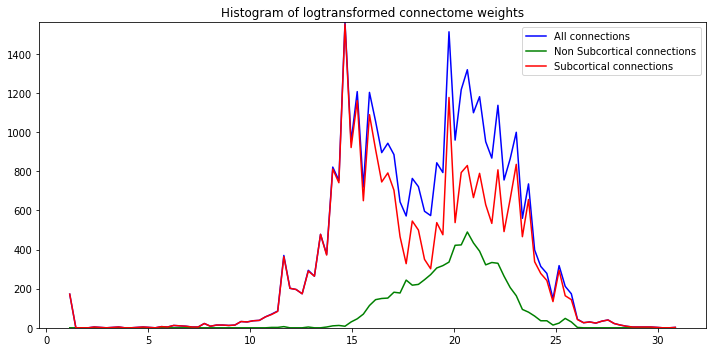

In [7]:
h = w[wp].flatten()
print('number of all connections > 0: %d' % h.size)
h, bins = np.histogram(h, range=(1.0, 31), bins=100)

w_within_sub = w[inds["subcrtx_not_thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]]
w_from_sub = w[inds["not_subcrtx_not_thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]]
w_to_sub = w[inds["subcrtx_not_thalspec"][:, None], inds["not_subcrtx_not_thalspec"][None, :]]
h_sub = np.array(w_within_sub.flatten().tolist() +
                 w_from_sub.flatten().tolist() + 
                 w_to_sub.flatten().tolist())
h_sub = h_sub[h_sub>0].flatten()
print('number of h_sub > 0: %d' % h_sub.size)
h_sub, bins_sub = np.histogram(h_sub, range=(1.0, 31), bins=100)
assert np.all(bins == bins_sub)

h_crtx = np.array(w[inds["not_subcrtx_not_thalspec"][:, None], 
                    inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
h_crtx = h_crtx[h_crtx>0]
print('number of h_crtx > 0: %d' % h_crtx.size)
h_crtx, bins_crtx = np.histogram(h_crtx, range=(1.0, 31), bins=100)
assert np.all(bins == bins_crtx)

h2 = h_crtx + h_sub
print('number of total > 0: %d' % np.sum(h2))

x = bins[:-1] + np.diff(bins)/2
plt.figure(figsize=(10, 5))
plt.plot(x, h, 'b', label='All connections')
plt.plot(x, h_crtx, 'g', label='Non Subcortical connections')
plt.plot(x, h_sub, 'r', label='Subcortical connections')
# plt.plot(x, h-h_sub, 'r--', label='All - Subcortical connections')
# plt.plot(x, h-h_crtx, 'g--', label='All - Non Subcortical connections')
# plt.plot(x, h2, 'k--', label='Total connections')
plt.title("Histogram of logtransformed connectome weights")
plt.legend()
plt.ylim([0.0, h.max()])
plt.tight_layout()

In [8]:
from tvb.datatypes.connectivity import Connectivity

# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

# w = weights.copy()
# w[np.isnan(w)] = 0.0
# # p99 = np.percentile(w, 99)
# # w[w>p99] = p99
# w[w<1e-3] = 0.0
# # w.max()
# wp = w>0
# w0 = w<=0
# w[wp] = np.log(w[wp])
# w -= (w.min()+1)
# w[w0] = 0.0
connectivity = Connectivity(centres=centres, region_labels=region_labels, 
                            weights=w, tract_lengths=tract_lengths)

# Selectively scale up some connections, if required:
for reg1, reg2, sc in BRAIN_CONNECTIONS_TO_SCALE:
    iR1 = np.where([reg in reg1 for reg in connectivity.region_labels])[0]
    iR2 = np.where([reg in reg2 for reg in connectivity.region_labels])[0]
    connectivity.weights[iR1, iR2] *= sc
    
# Normalize connectivity weights
connectivity.weights[np.logical_or(np.isnan(connectivity.weights), np.isinf(connectivity.weights))] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.tract_lengths = np.maximum(connectivity.speed * dt, 
                                        connectivity.tract_lengths)

connectivity.configure()

# # Plot TVB connectome:
# plotter.plot_tvb_connectivity(connectivity);


In [9]:

# -----------------------------------Build cosimulator manually--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial

simulator = CoSimulatorSerial()

simulator.connectivity = connectivity



/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, device_set=pd.Series(), **kwargs):


In [10]:
if FIC:
    from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import \
        WilsonCowanThalamoCorticalFIC as WilsonCowanThalamoCortical
else:
    from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import WilsonCowanThalamoCortical
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn


dummy = np.ones((simulator.connectivity.number_of_regions,))

# G normalized by the number of regions as in Griffiths et al paper
Geff = G /(simulator.connectivity.number_of_regions - inds['thalspec'].size)
I_e = I_e*dummy
I_e[inds["subcrtx_not_thalspec"]] = -0.75 # -0.35
model_params = {"G": np.array([Geff]), 
                'I_o': np.array([I_o]), 
                'I_e': I_e #, # np.array([I_e]), 
                # 'I_s': np.array([I_s])
               } # - 49*Geff  -3.5 / -2 / -1.5, -1.6 / -1.25 / -1.0
# if DEMO:
#     model_params.update({'w_ee': np.array([1.4]), 
#                          'w_ei': np.array([1.4]), 
#                          'w_ie': np.array([-3.0]),
#                          'w_se': np.array([1.65]),
#                          'tau_e': np.array([10.0/0.9]), 
#                          'tau_i': np.array([10.0/0.9]),
#                          'tau_s': np.array([10.0/0.25]), 
#                          'tau_r': np.array([10.0/0.25])
#                         })
 
if STIMULUS:
    # Stimuli:
    A_st = 0*dummy.astype("f")
    f_st = 0*dummy.astype("f")
    if TEST:
        # M1:
        A_st[[44, 166]] = STIMULUS
        f_st[[44, 166]] = 6.0 # Hz
    else:
#         # Sensory to Medulla SPV
#         A_st[inds["trigeminal"]] = STIMULUS
#         f_st[inds["trigeminal"]] = 6.0 # Hz
#         # Motor to Facial nucleus
#         A_st[inds["facial"]] = STIMULUS
#         f_st[inds["facial"]] = 6.0 # Hz
        # Stimulus to M1 
        A_st[inds["motor"][:2]] = STIMULUS
        f_st[inds["motor"][:2]] = 6.0 # Hz
        # ...and S1 barrel field
        A_st[inds["sens"][-2:]] = STIMULUS
        f_st[inds["sens"][-2:]] = 6.0 # Hz
    model_params.update({"A_st": A_st, "f_st": f_st})

simulator.model = WilsonCowanThalamoCortical(is_cortical=is_cortical[:, np.newaxis], 
                                             is_thalamic=is_thalamic[:, np.newaxis],
                                             **model_params)
simulator.model.dt = dt
simulator.model.test_mode = TEST

# Specific thalamic relay -> nonspecific subcortical structures connections' weights:
w_se = simulator.model.w_se * dummy
w_se[inds['subcrtx']] = simulator.model.G[0]
simulator.model.w_se = w_se
# Remove specific thalamic relay -> inhibitory nonspecific subcortical structures connections 
w_si = simulator.model.w_si * dummy
w_si[inds['subcrtx']] = 0.0*simulator.model.G[0]
simulator.model.w_si = w_si
# #  Nonspecific subcortical -> specific thalamic relay and reticular structures connections' weights:
# simulator.model.G = simulator.model.G * dummy
# simulator.model.G[inds["thalspec"]] = 0.0
# # The following seems redundant given the above zeroings!:
# simulator.connectivity.weights[inds["thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]] = 0.0
# simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["thalspec"][None, :]] = 0.0

# h1, bins = np.histogram(simulator.connectivity.weights[wp].flatten(), range=(0.0, 1.25), bins=100)
# h_sub1 = np.array(simulator.connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
#                                                  inds["subcrtx_not_thalspec"][None, :]].flatten().tolist() +
#                   simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
#                                                  inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
# h_sub1, bins = np.histogram(h_sub1[h_sub1>0].flatten(), range=(0.0, 1.25), bins=100)

# Homogenize crtx <-> subcrtx connnectivity
# simulator.connectivity.weights[inds["crtx"][:, None], inds["subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02
# simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["crtx"][None, :]] *= 0.0 # 0.0 # 0.02

# # Disconnect subcortex completely
# simulator.connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
#                                inds["subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02
# simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
#                                inds["not_subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02

# Variability to thalamocortical connections:
if THAL_CRTX_FIX:
    
    if "w" in THAL_CRTX_FIX:
        # Fix structural connectivity (specific) thalamo-cortical weights to 1, 
        # such that all thalamo-cortical weights are equal to the parameters 
        # w_er, w_es, w_se, w_si
        simulator.connectivity.weights[inds["crtx"], inds["thalspec"]] = 1.0
        simulator.connectivity.weights[inds["thalspec"], inds["crtx"]] = 1.0
        
    if "d" in THAL_CRTX_FIX:
        # Fix structural connectivity (specific) thalamo-cortical tracts length to a value, 
        # such that all thalamo-cortical delays are equal to the parameter tau_ct,
        # given connectivity's speed.
        ct_lengths = simulator.connectivity.speed * \
                     simulator.model.tau_ct * np.ones((simulator.connectivity.number_of_regions, ))[inds["crtx"]]
        simulator.connectivity.tract_lengths[inds["crtx"], inds["thalspec"]] = ct_lengths
        simulator.connectivity.tract_lengths[inds["thalspec"], inds["crtx"]] = ct_lengths
        
    simulator.connectivity.configure()
if not THAL_CRTX_FIX or "d" not in THAL_CRTX_FIX:
    tau_ct = simulator.model.tau_ct * dummy
    tau_ct[inds['crtx']] = simulator.connectivity.delays[inds["thalspec"], inds["crtx"]]
    tau_ct[inds['thalspec']] = simulator.connectivity.delays[inds["crtx"], inds["thalspec"]]
    simulator.model.tau_ct = tau_ct
        
# h_sub2 = np.array(simulator.connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
#                                                  inds["subcrtx_not_thalspec"][None, :]].flatten().tolist() +
#                   simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
#                                                  inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
# h_sub2, bins = np.histogram(h_sub2[h_sub2>0].flatten(), range=(0.0, 1.25), bins=100)
# wp = simulator.connectivity.weights > 0
# h2, bins = np.histogram(simulator.connectivity.weights[wp].flatten(), range=(0.0, 1.25), bins=100)

# x = bins[:-1] + np.diff(bins)/2
# plt.figure(figsize=(10, 5))
# plt.plot(x, h1, 'b', label='All connections before downscaling')
# plt.plot(x, h2, 'b--', label='All connections after downscaling')
# plt.plot(x, h_sub1, 'r', label='Subcortical connections before downscaling')
# plt.plot(x, h_sub2, 'r--', label='Subcortical connections after downscaling')
# plt.title("Histogram of logtransformed connectome weights\nwith downscaling connections")
# plt.legend()
# plt.ylim([0.0, h1.max()])
# plt.tight_layout()


Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 5 * indegree / 108.485 = 0.00921785 * indegree


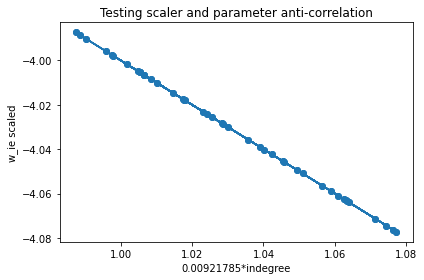

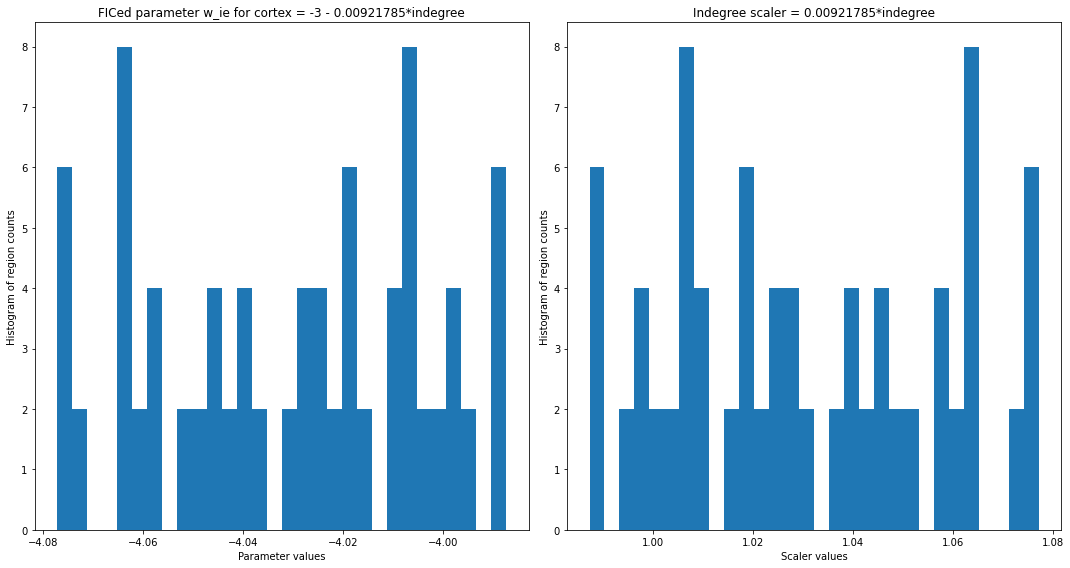

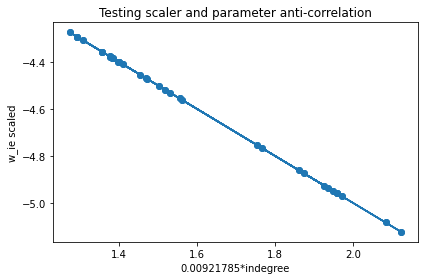

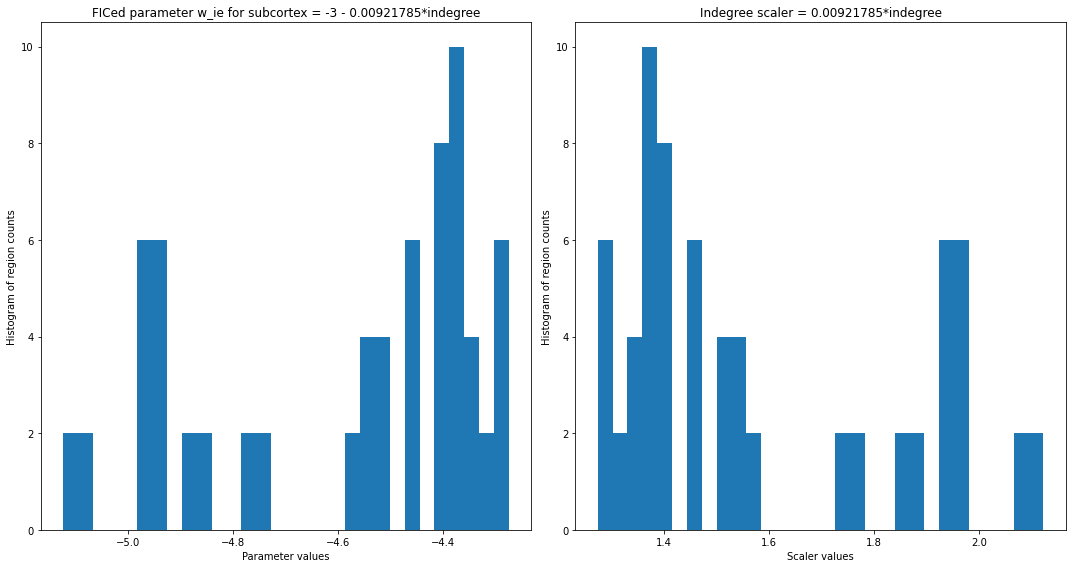

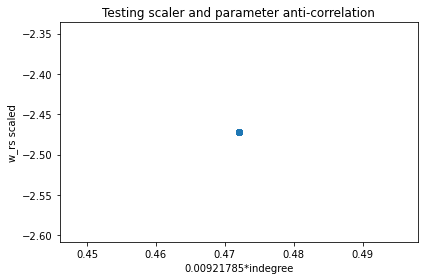

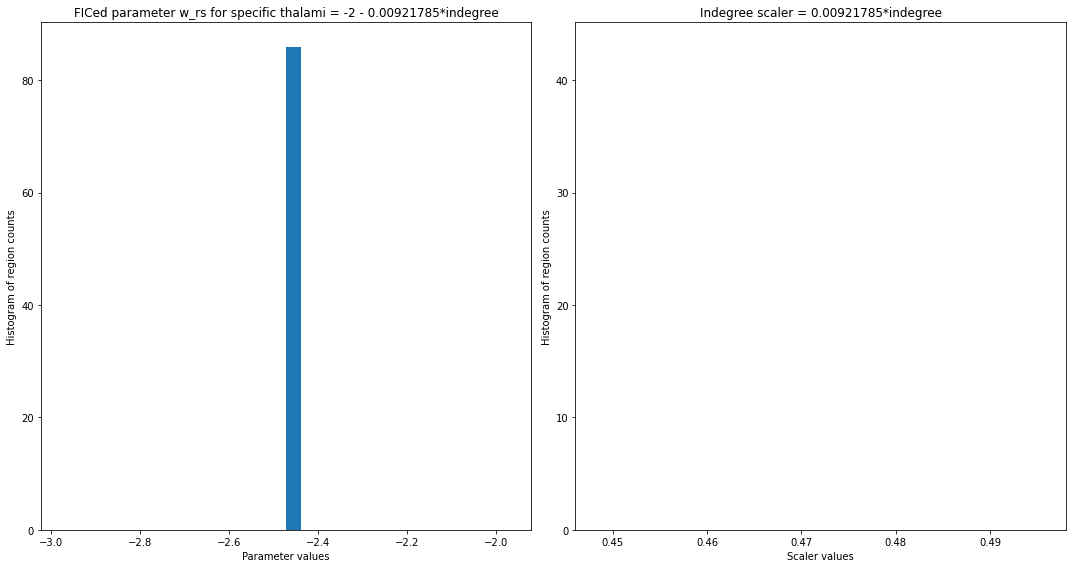

In [11]:
# An approximate automatic FIC:

def fic(param, trg_inds=None, src_inds=None, FIC=1.0, p_orig=None, dummy=None, subtitle=""):
    
    if trg_inds is None:
        trg_inds = np.arange(simulator.connectivity.number_of_regions).astype('i')
        
    if src_inds is None:
        src_inds = np.arange(simulator.connectivity.number_of_regions).astype('i')
    
    # Scale w_ie to grow to greater negative values from the default w_ie = -2.0
    if p_orig is None:
        p_orig = getattr(simulator.model, param)
    p_orig = np.array(p_orig)
    if p_orig.size == 1:
        if dummy is None:
            dummy = np.ones((simulator.connectivity.number_of_regions))
            p_orig = p_orig.item() * dummy
    p = p_orig.copy()
    p_orig = p_orig[trg_inds].mean().item()
    # Move them to have a maximum of w_ie = -2.0:
    win = simulator.connectivity.weights[trg_inds][:, src_inds].sum(axis=1).flatten()
    scaler = FIC*win
    p[trg_inds] = p[trg_inds] - scaler
    
    try:
        assert np.all(np.argsort(win) == np.argsort(-p[trg_inds])) # the orderings should reverse
    except:
        plt.figure()
        plt.plot(scaler, p[trg_inds], "-o")
        plt.xlabel("%g*indegree" % FIC)
        plt.ylabel("%s scaled" % param)
        plt.title("Testing scaler and parameter anti-correlation")
        plt.tight_layout()
        
    # Plot and confirm:
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[1].hist(scaler, 30)
    axes[1].set_xlabel("Scaler values")
    axes[1].set_ylabel("Histogram of region counts")
    axes[1].set_title("Indegree scaler = %g*indegree" % FIC)
    axes[0].hist(p[trg_inds], 30)
    axes[0].set_xlabel("Parameter values")
    axes[0].set_ylabel("Histogram of region counts")
    axes[0].set_title("FICed parameter %s%s = %g - %g*indegree" % (param, subtitle, p_orig, FIC))
    fig.tight_layout()
    return p


if FIC and G > 0.0:

    mean_indegree = simulator.connectivity.weights.sum(axis=1).mean()
    FICeff = FIC*G/mean_indegree
    print("Effective FIC = FIC * G * indegree / mean_indegree = %g * %g * indegree / %g = %g * indegree" 
          % (FIC, G, mean_indegree, FICeff))
    # Indices of cortical and subcortical regions excluding specific thalami
    inds["non_thalamic"] = np.unique(inds['crtx'].tolist() + inds["subcrtx_not_thalspec"].tolist())
        
    # FIC for cortical w_ie against indegree for all incoming connections exluding the ones from specific thalami
    simulator.model.w_ie = fic("w_ie", inds["crtx"], inds["non_thalamic"], 
                               FIC=FICeff, dummy=None, subtitle=" for cortex")
    
    w_to_subcrtx = simulator.connectivity.weights[inds["subcrtx_not_thalspec"]].sum()
    if w_to_subcrtx:
        # FIC for subcortical w_ie against indegree for all incoming connections including the ones from specific thalami
        simulator.model.w_ie = fic("w_ie", inds["subcrtx_not_thalspec"], src_inds=None,  
                                   FIC=FICeff, dummy=None, subtitle=" for subcortex")
    
    w_subcrtx_to_thal = simulator.connectivity.weights[inds["thalspec"]][:, inds["subcrtx_not_thalspec"]].sum()
    if w_subcrtx_to_thal:
        # FIC for specific thalami w_rs against indegree for incoming connections from subcortical regions
        simulator.model.w_rs = fic("w_rs", inds["thalspec"], inds["subcrtx_not_thalspec"], 
                                   FIC=FICeff, dummy=None,  subtitle=" for specific thalami")
    

In [12]:
from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import SigmoidalPreThalamoCortical
from tvb.simulator.integrators import EulerStochastic, HeunStochastic
from tvb.simulator.monitors import Raw, Bold, TemporalAverage

simulator.coupling = SigmoidalPreThalamoCortical(
                        is_thalamic=is_thalamic,
                        is_subcortical=is_subcortical,
                        sigma=np.array([1.0]),
                        midpoint=simulator.model.sigma, 
                        cmin=np.array([0.0]), 
                        cmax=np.array([1.0]), 
                        a=simulator.model.beta) 

simulator.integrator = HeunStochastic()  # EulerStochastic() # HeunStochastic()  #
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([NOISE] * (simulator.model.nvar-1) + [0.0]) # config.DEFAULT_NSIG = 0.001

simulator.initial_conditions = 0.1*np.random.normal(size=(1000, simulator.model.nvar, connectivity.number_of_regions, 1))

if FIC:
    simulator.initial_conditions[:, -1, is_thalamic, :] = simulator.model.w_rs[None, is_thalamic, None]
    simulator.initial_conditions[:, -1, not_thalamic, :] = simulator.model.w_ie[None, not_thalamic, None]
    simulator.model.eta = np.array([-0.05])
    
mon_raw = Raw(period=1.0)  # ms
bold = Bold(period=1024.0, variables_of_interest=np.array([2]))  # !!! Set a proper (1-2 sec??) TR time in ms !!!
simulator.monitors = (mon_raw, bold)
simulator.configure()

simulator.integrate_next_step = simulator.integrator.integrate_with_update

simulator.print_summary_info_details(recursive=1)


2022-05-19 08:36:20,425 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title ........................... 'CoSimulatorSerial gid: b0864839-21b6-44be-b101-bd13d31b899a'
  Type ............................ 'CoSimulatorSerial'
  model ........................... WilsonCowanThalamoCorticalFIC gid: 70f0fc97-5415-41c9-a33f-05e9c0ef4e46
  output_interfaces ............... None
  input_interfaces ................ None
  out_proxy_inds .................. --------------------
  shape ........................... (0,)
  dtype ........................... int64
  is empty ........................ True
  exclusive ....................... False
  voi ............................. --------------------
  proxy_inds ...................... --------------------
  synchronizat

## 4. Configure simulator, simulate, gather results

In [13]:
# Simulate!

# Set the simulation time:
simulation_length =  10000.0  # for reasonable resting state, use about 1 min = 60 sec = 60000.0 ms + transient
transient = 0.1
if FIC is None:
    transient *= simulation_length
    simulation_length += transient
simulator.simulation_length = simulation_length

import time
tic = time.time()
results = simulator.run()
print("\nSimulated in %f secs!" % (time.time() - tic))



Simulated in 1036.343907 secs!


## 5. Plot results and write them to HDF5 files

In [14]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 2
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [15]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
bold_ts = None

if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    print("Raw ts:\n%s" % str(source_ts))
    
    if len(results) > 1:
        bold_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
                data=results[1][1], time=results[1][0],
                connectivity=simulator.connectivity,
                labels_ordering=["Time", "State Variable", "Region", "Neurons"],
                labels_dimensions={"State Variable": ["BOLD"],
                                   "Region": simulator.connectivity.region_labels.tolist()})
        bold_ts.configure()

        bold_t = source_ts.time

        # Write to file
        if writer:
            writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(bold_ts._data,
                                                                            connectivity=bold_ts.connectivity),
                                   os.path.join(config.out.FOLDER_RES, bold_ts.title)+".h5")
        print("BOLD ts:\n%s" % str(bold_ts))
    

Raw ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 100000
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 0.09999999999999999
  Source Connectivity . Connectivity gid: ea147bb0-5054-4ac9-9e0c-55c45b38f67a
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-13.6699, -0.220265, 4.45459]
  dtype ............... float64
  shape ............... (100000, 4, 242, 1)
)
BOLD ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 9
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 1024.0
  Source Connectivity . Connectivity gid: ea147bb0-5054-4ac9-9e0c-55c45b38f67a
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-1.15177, -0.

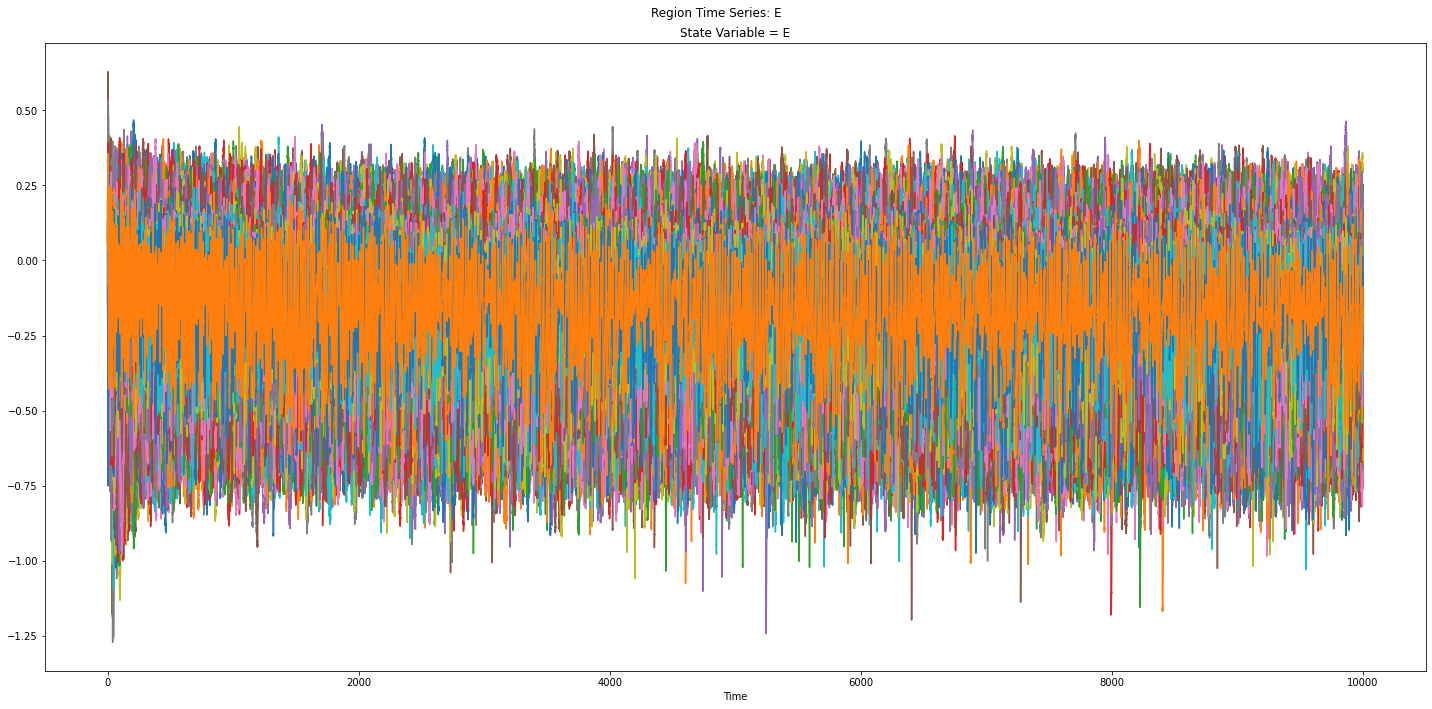

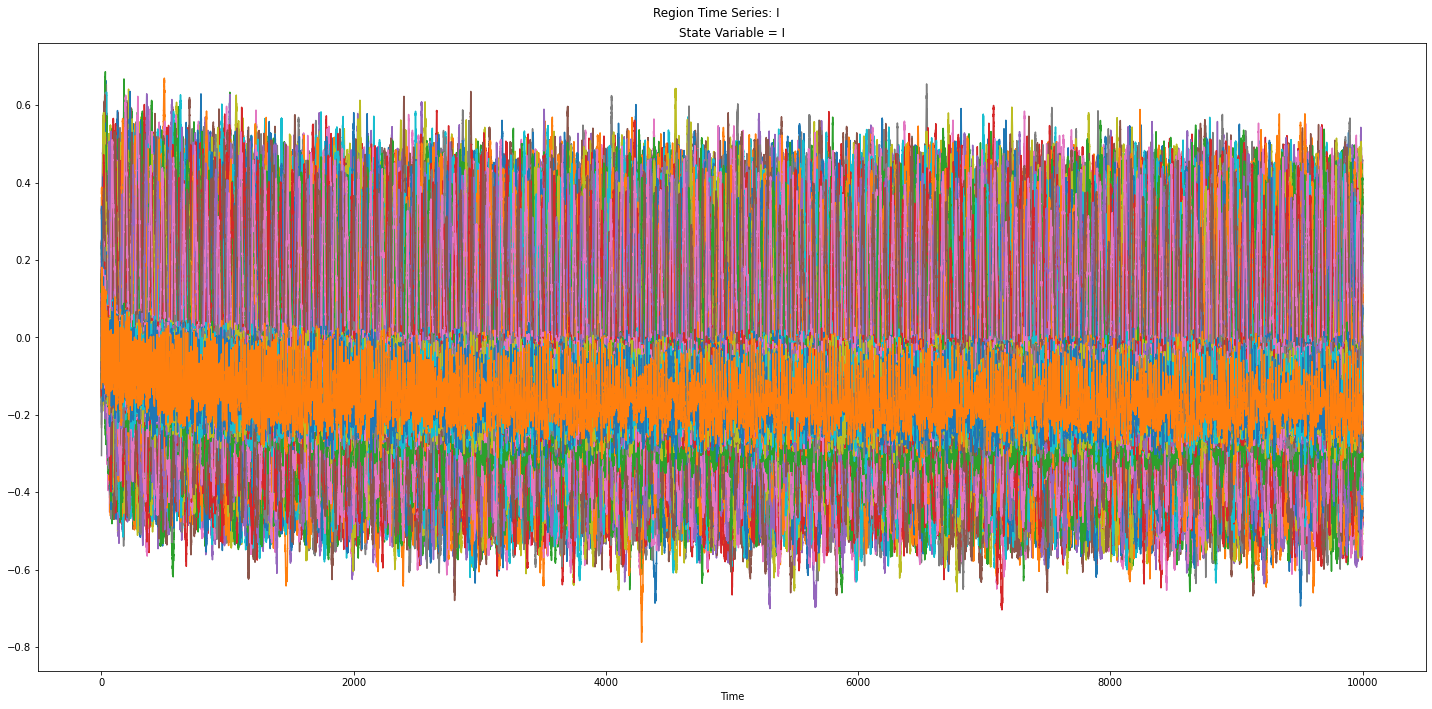

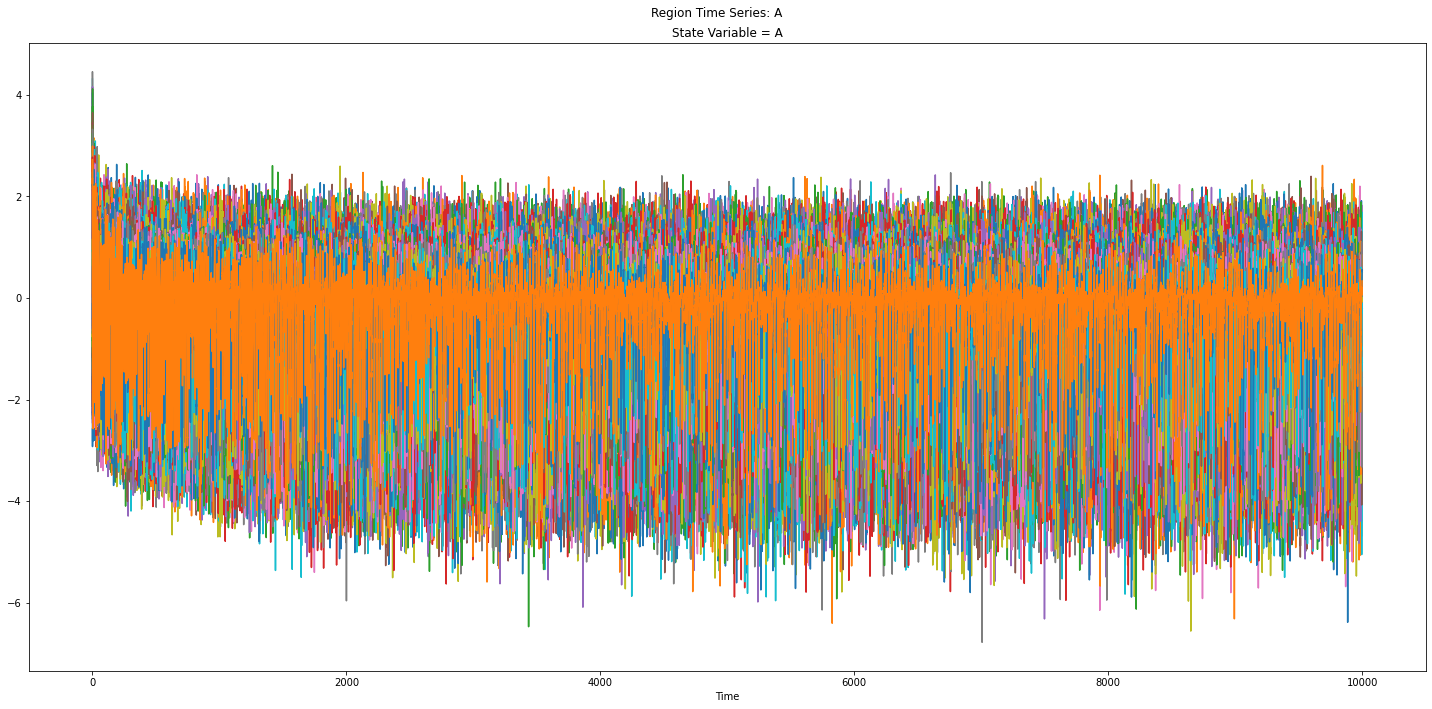

In [16]:
# Plot TVB time series
if source_ts is not None:
    source_ts[:, :, :, :].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

2022-05-19 08:55:57,975 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:55:57,982 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


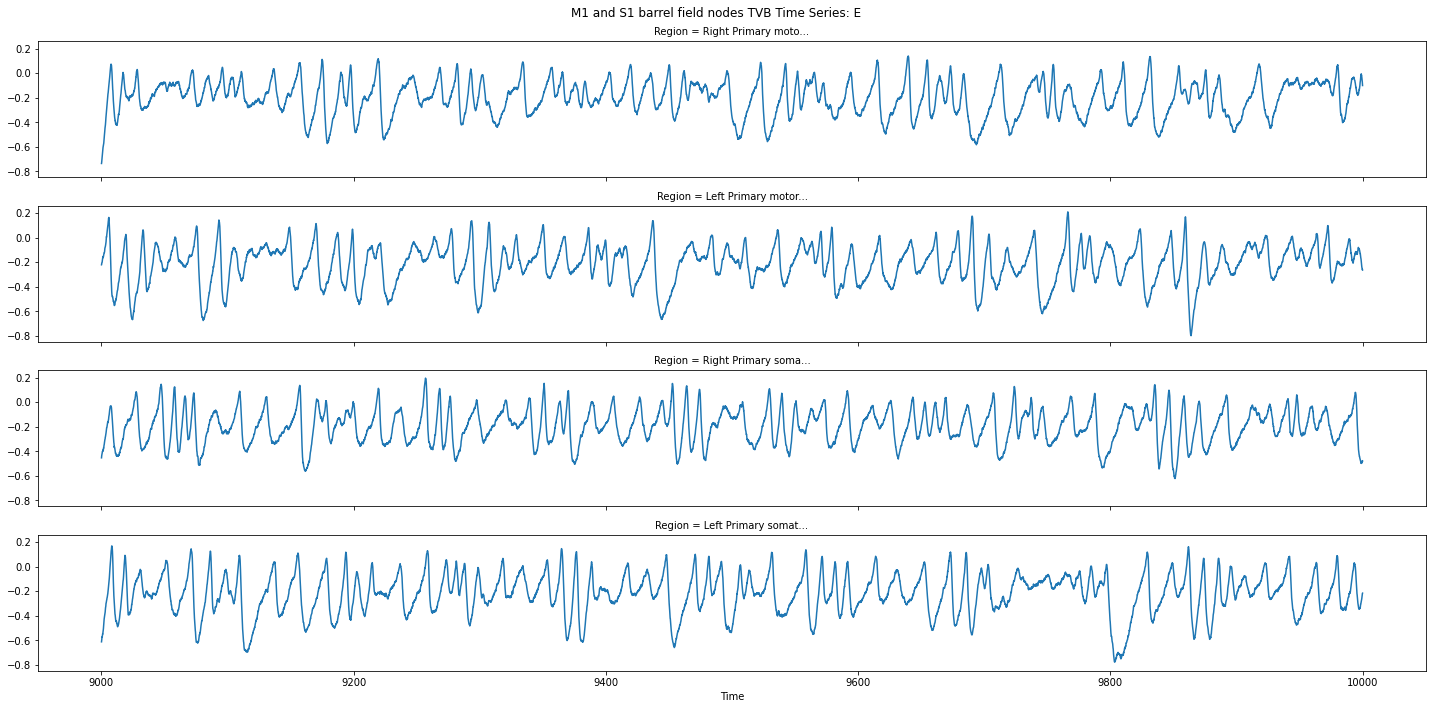

2022-05-19 08:55:59,096 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


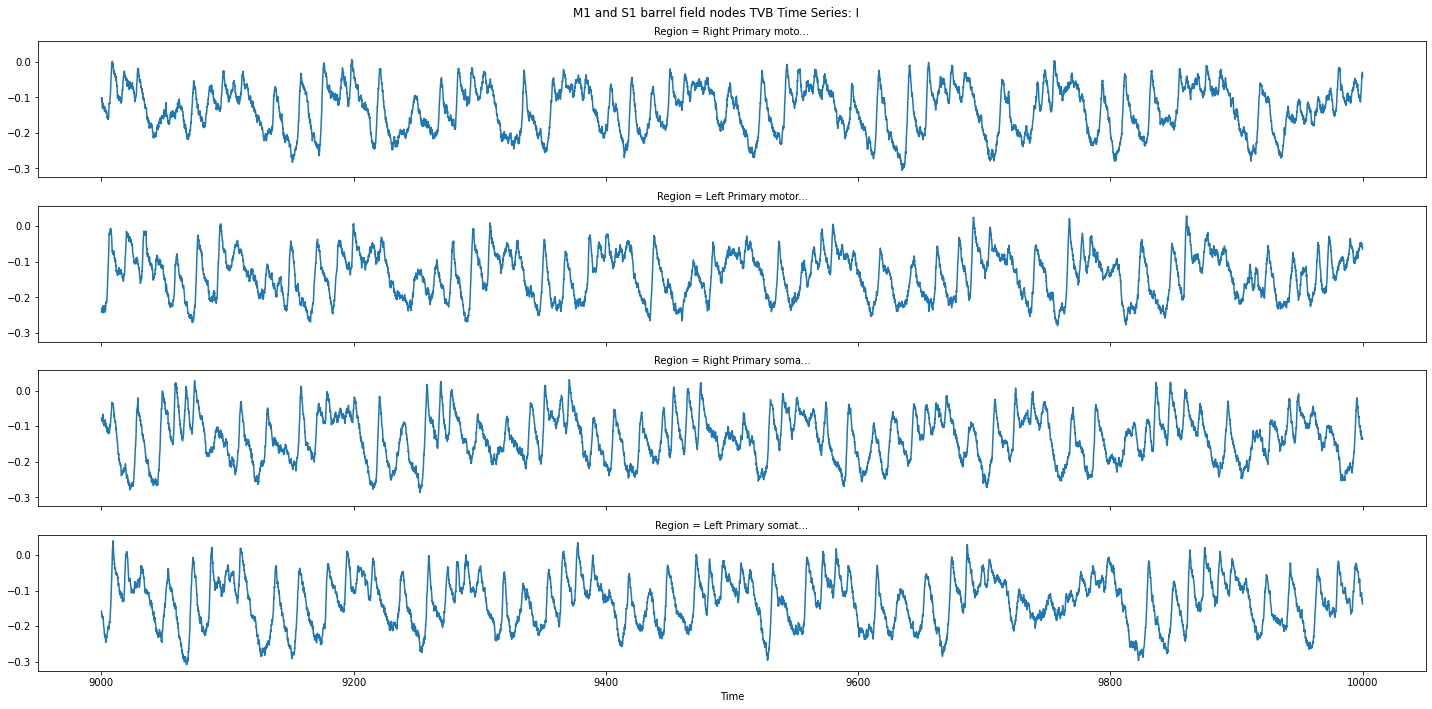

2022-05-19 08:56:00,185 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


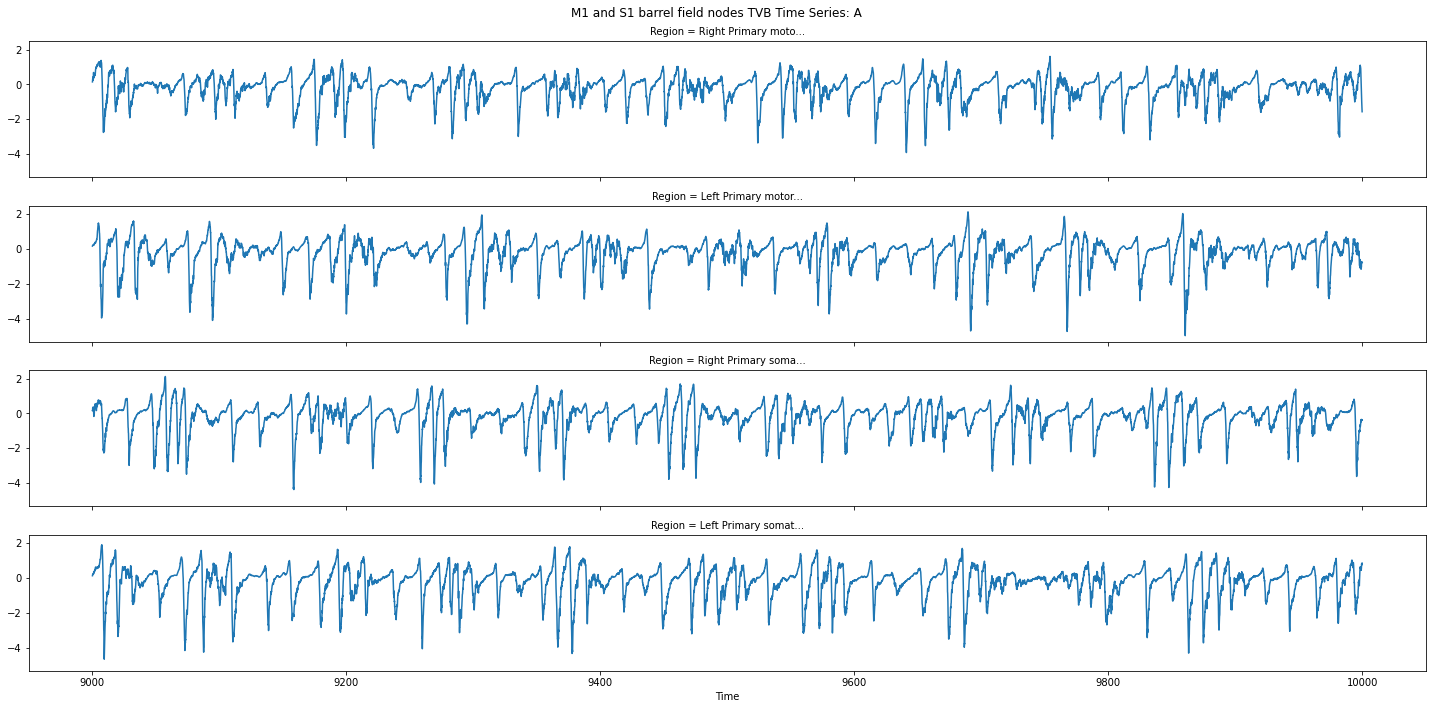

2022-05-19 08:56:01,326 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


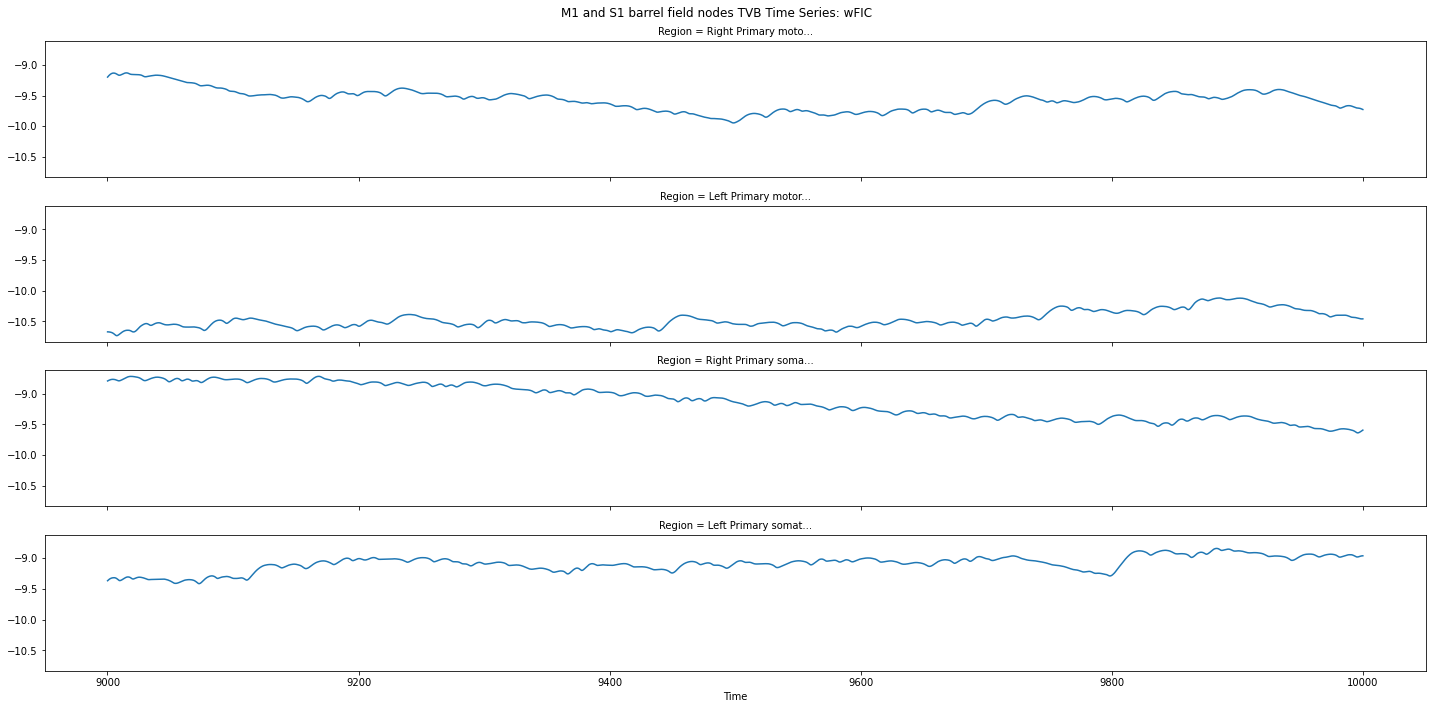

In [17]:
# Focus on the m1 and s1 barrel field nodes: 
if source_ts is not None:
    source_ts_m1s1brl = source_ts[-10000:, :, inds["m1s1brl"]]
    source_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series");

In [18]:
# Focus on the m1 and s1 barrel field nodes: raster plot
if source_ts is not None and source_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series Raster");

2022-05-19 08:56:02,668 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:56:02,730 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


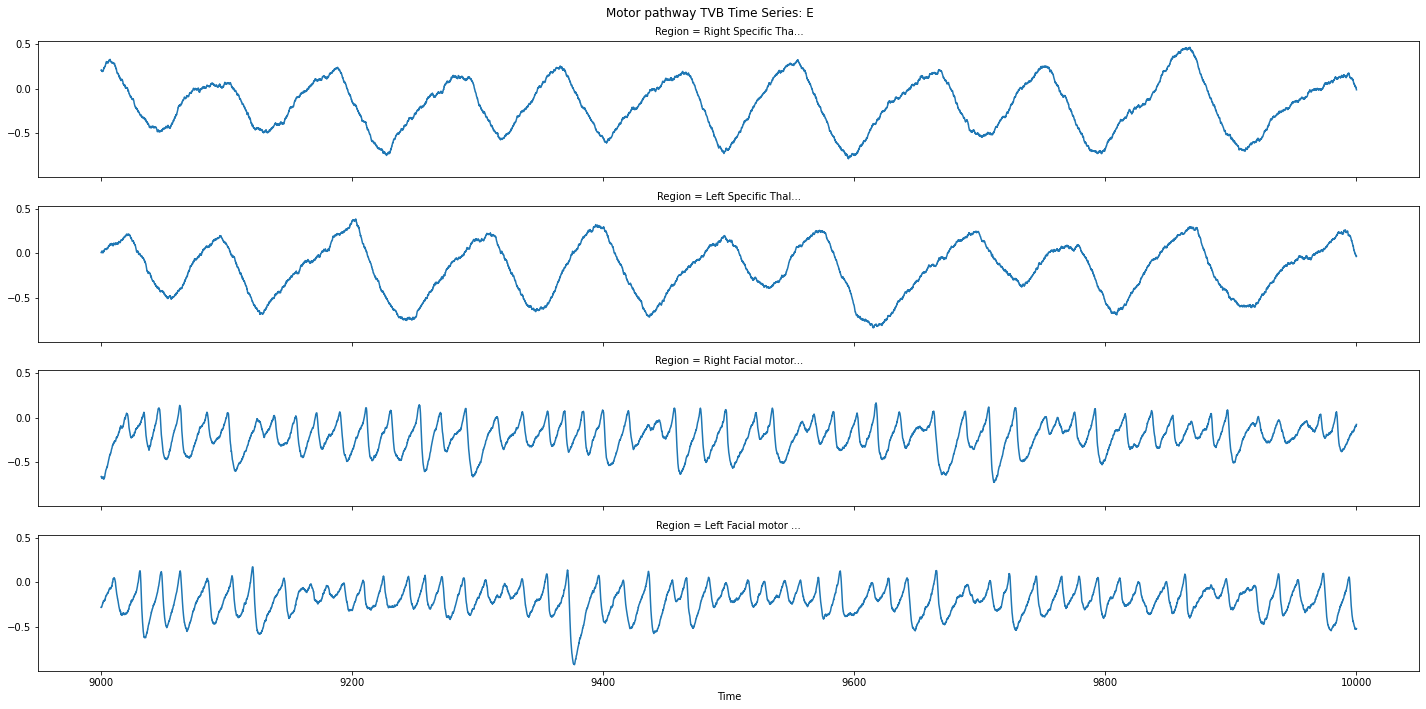

2022-05-19 08:56:04,754 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


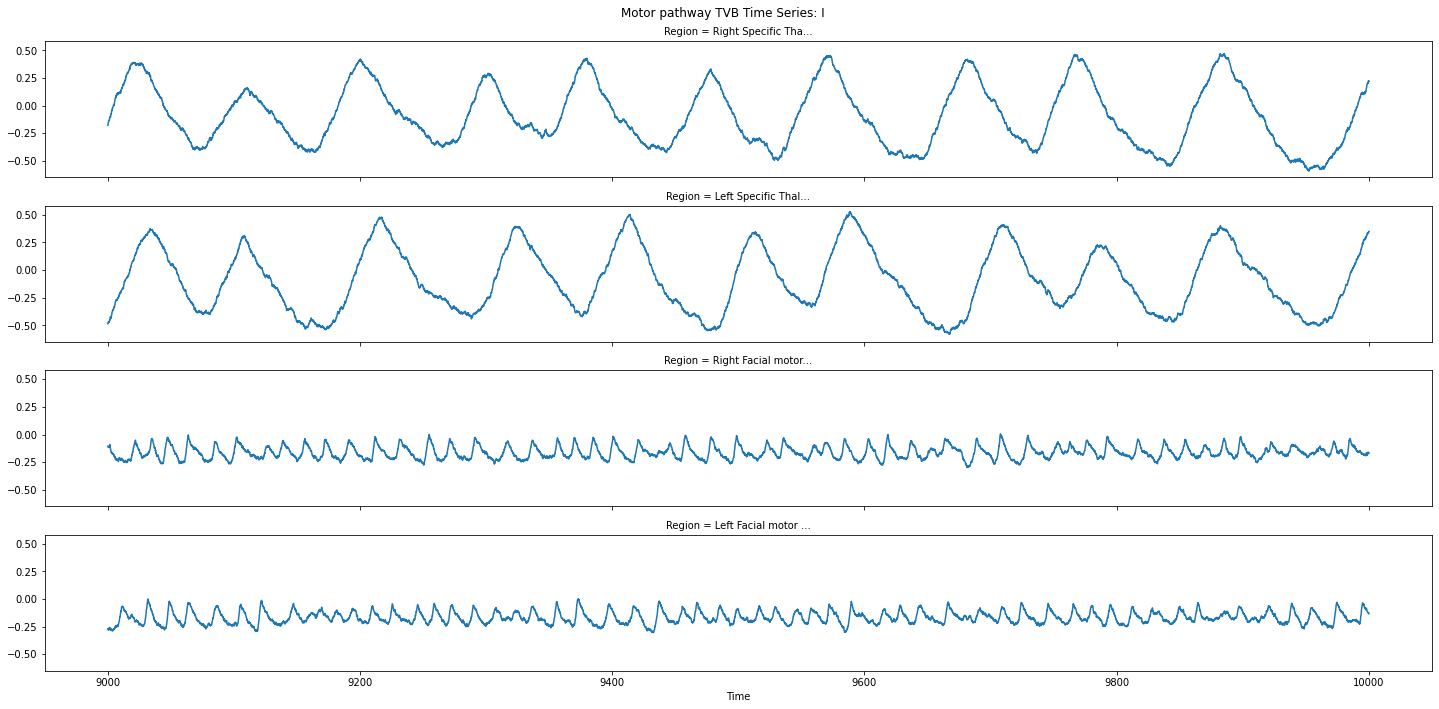

2022-05-19 08:56:06,057 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


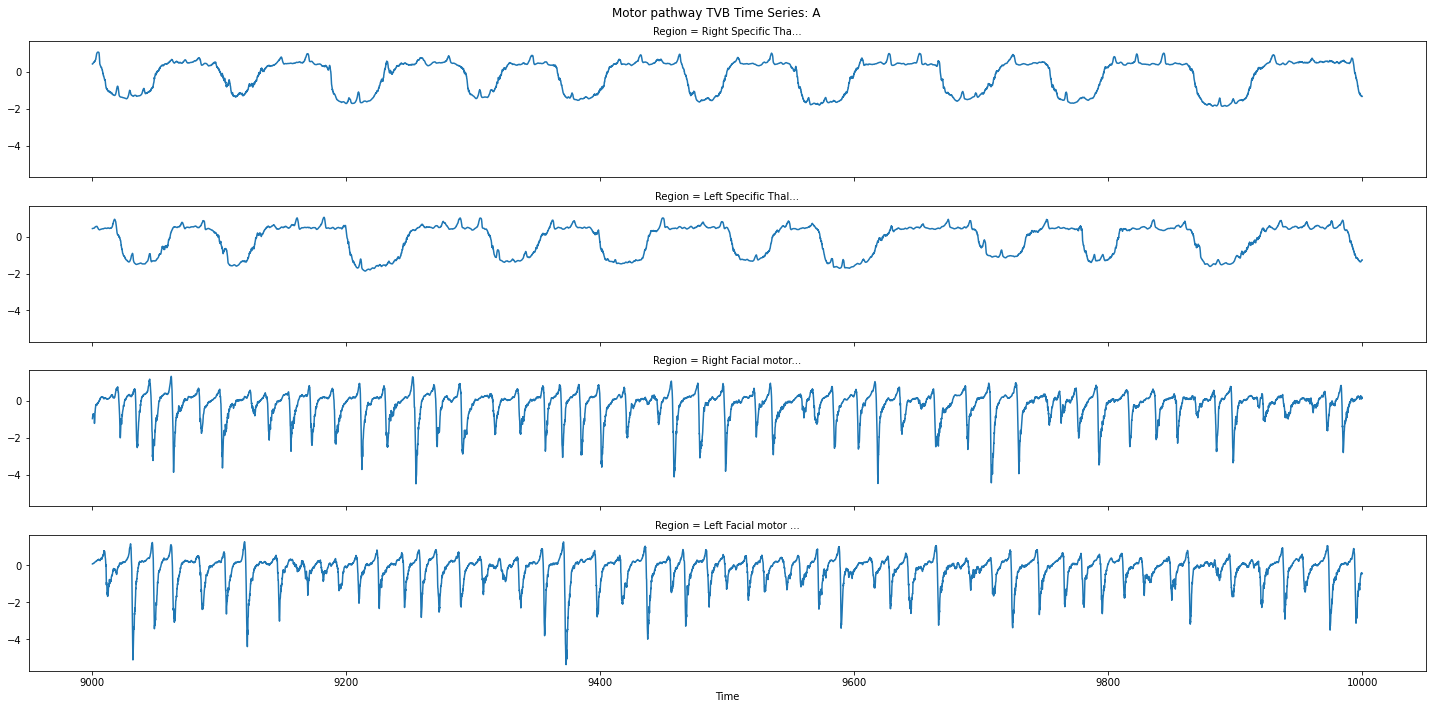

2022-05-19 08:56:07,007 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


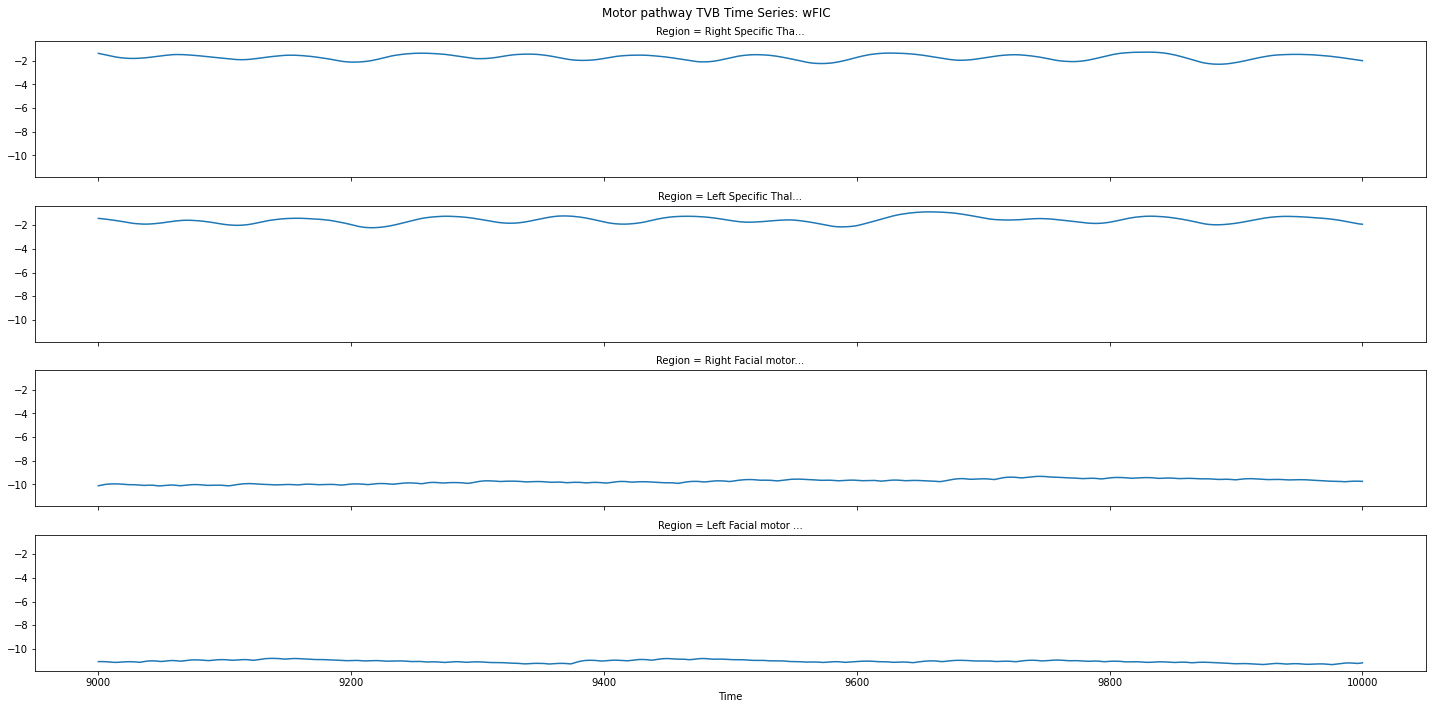

In [19]:
# Focus on the the motor pathway: 
if source_ts is not None:
    source_ts_motor = source_ts[-10000:, :, inds["motor"]]
    source_ts_motor.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Motor pathway TVB Time Series");

In [20]:
# Focus on the motor pathway: raster plot
if source_ts_motor is not None and source_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_motor.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="Motor pathway TVB Time Series Raster");

2022-05-19 08:56:07,908 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:56:07,915 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


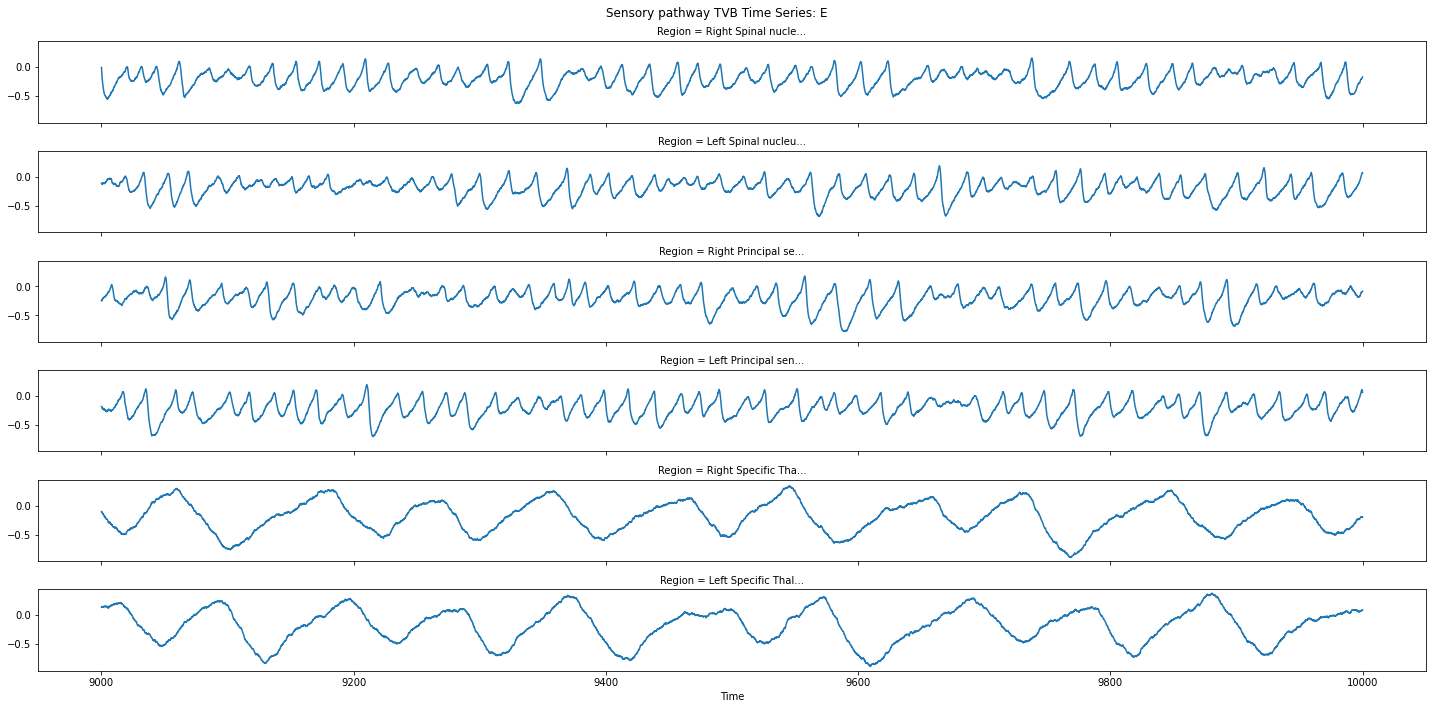

2022-05-19 08:56:09,136 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


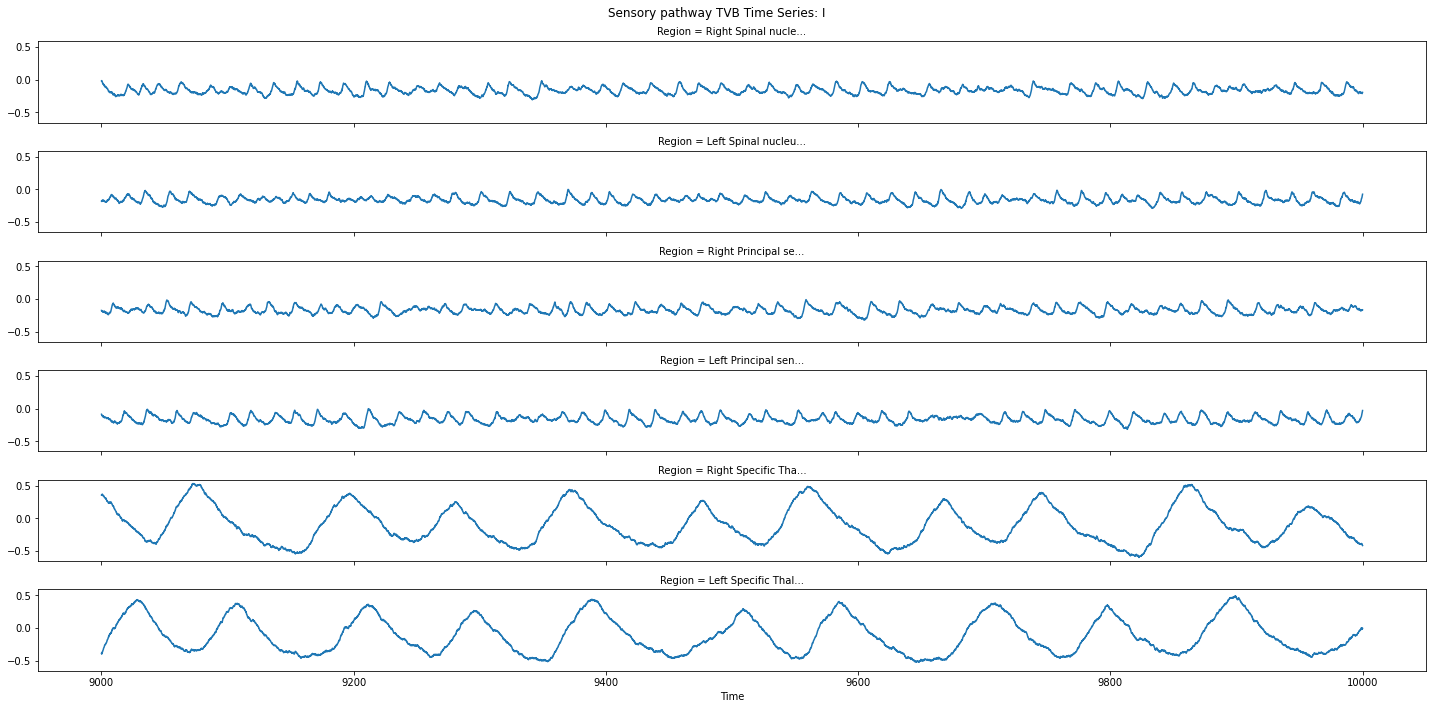

2022-05-19 08:56:10,374 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


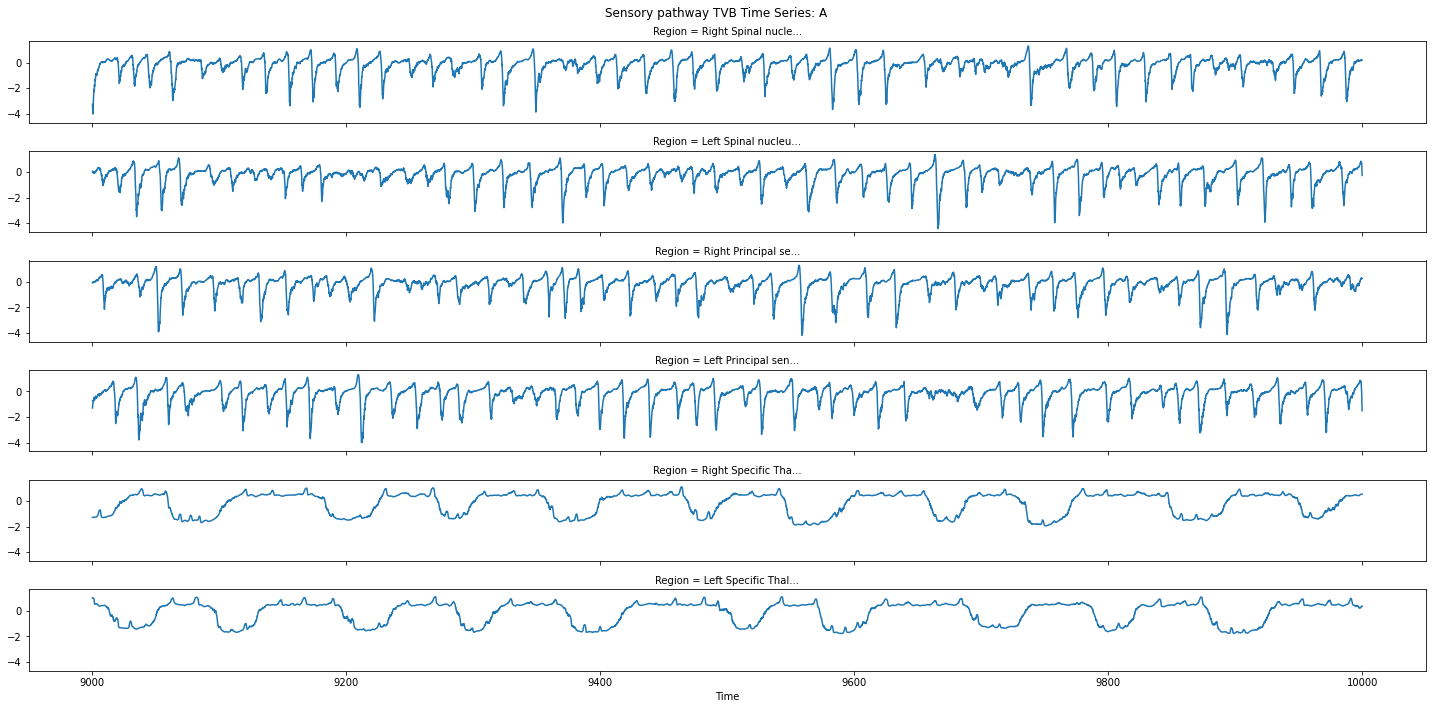

2022-05-19 08:56:12,333 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


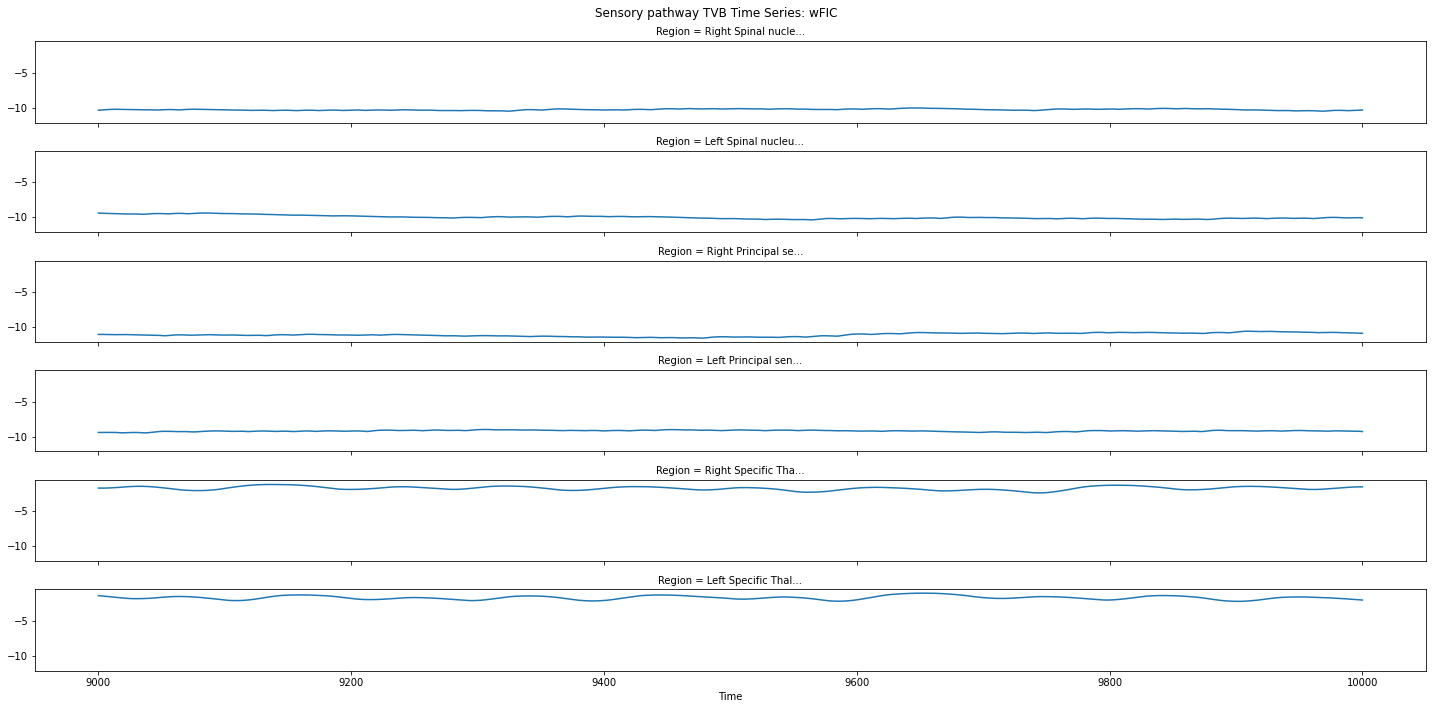

In [21]:
# Focus on the sensory pathway: 
if source_ts is not None:
    source_ts_sens = source_ts[-10000:, :, inds["sens"]]
    source_ts_sens.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Sensory pathway TVB Time Series");

In [22]:
# Focus on the sensory pathway: raster plot
if source_ts is not None and source_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_sens.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Sensory pathway TVB Time Series Raster");

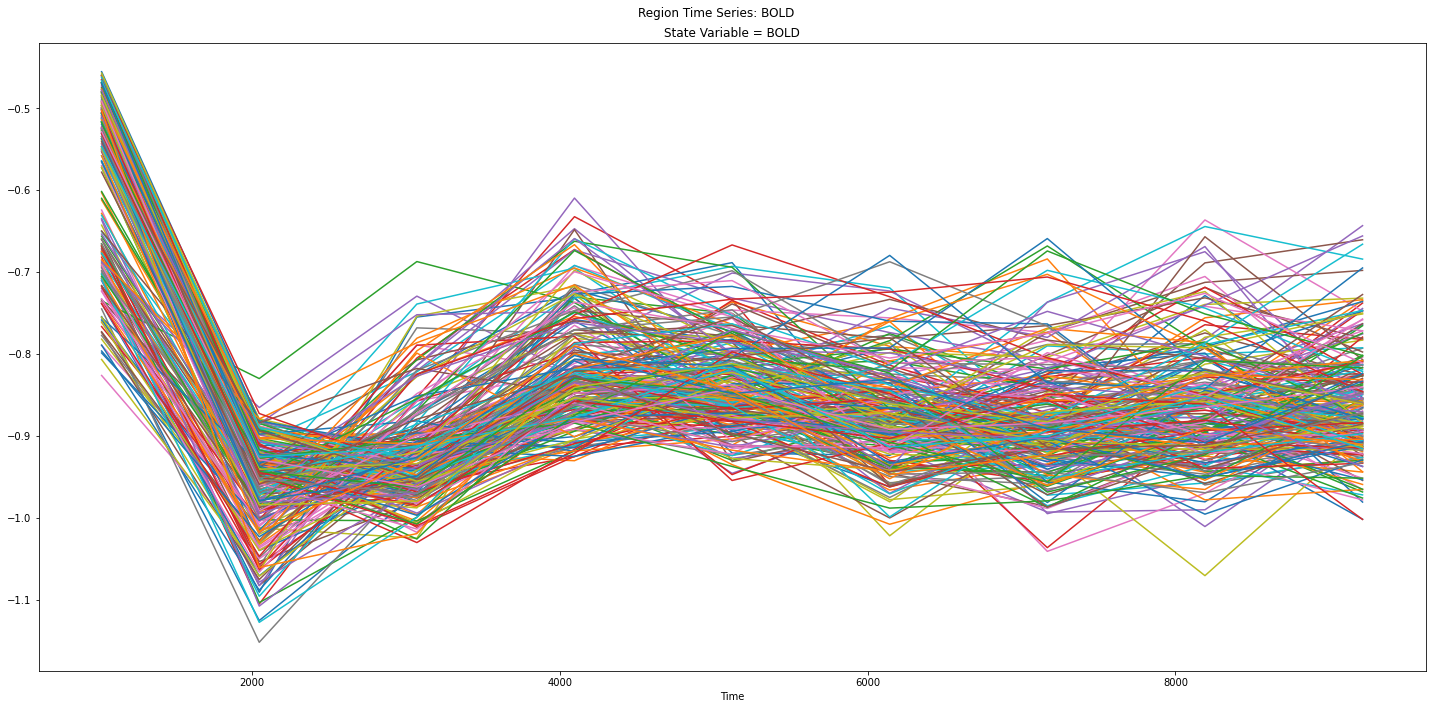

In [23]:
# bold_ts TVB time series
if bold_ts is not None:
    bold_ts.plot_timeseries(plotter_config=plotter.config, 
                            hue="Region" if bold_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                            per_variable=bold_ts.shape[1] > MAX_VARS_IN_COLS, 
                            figsize=FIGSIZE);

In [24]:
# # Focus on the m1 and s1 barrel field nodes: 
# if bold_ts is not None:
#     bold_ts_m1s1brl = bold_ts[-10000:, :, inds["m1s1brl"]]
#     bold_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
#                                     hue="Region" if bold_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                     per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
#                                     figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series");

In [25]:
# # Focus on the m1 and s1 barrel field nodes: raster plot
# if bold_ts is not None and bold_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
#                                 per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
#                                 figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series Raster");

In [26]:
# # Focus on the the motor pathway: 
# if bold_ts is not None:
#     bold_ts_motor = bold_ts[-10000:, :, inds["motor"]]
#     bold_ts_motor.plot_timeseries(plotter_config=plotter.config, 
#                                    hue="Region" if bold_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                    per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
#                                    figsize=FIGSIZE, figname="Motor pathway BOLD Time Series");

In [27]:
# # Focus on the motor pathway: raster plot
# if bold_ts is not None and bold_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_motor.plot_raster(plotter_config=plotter.config, 
#                               per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS,
#                               figsize=FIGSIZE, figname="Motor pathway BOLD Time Series Raster");

In [28]:
# # Focus on the sensory pathway: 
# if bold_ts is not None:
#     bold_ts_sens = bold_ts[-10000:, :, inds["sens"]]
#     bold_ts_sens.plot_timeseries(plotter_config=plotter.config, 
#                                  hue="Region" if bold_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                  per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
#                                  figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series");

In [29]:
# # Focus on the sensory pathway: raster plot
# if bold_ts is not None and bold_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_sens.plot_raster(plotter_config=plotter.config, 
#                              per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS,
#                              figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series Raster");

### Interactive time series plot

In [30]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [31]:
# # For interactive plotting:
# %matplotlib notebook  


# from tvb.datatypes.time_series import TimeSeries
# from tvb.contrib.scripts.plot.power_spectra_interactive import PowerSpectraInteractive

# tsr = TimeSeries(data=source_ts[1000:, 0, inds["m1s1brl"]]._data.values, sample_period=source_ts.sample_period)
# psi = PowerSpectraInteractive()
# psi.time_series = tsr
# psi.window_length = 1000.0
# psi.show()
# from ipywidgets import interact, widgets as ip_widgets
# from IPython.display import display

# textRegions = ip_widgets.Text(
#     value='',
#     placeholder='Regions Slicer',
#     description='start:stop:step',
#     disabled=False
# )

# textFreqs = ip_widgets.Text(
#     value='',
#     placeholder='Frequency Range',
#     description='f_min, f_max',
#     disabled=False
# )

# def callbackRegions(wdgt):
#     # replace by something useful
#     psi.update_regions(wdgt.value)

# def callbackFreqs(wdgt):
#     # replace by something useful
#     psi.update_freq_range(wdgt.value)
    
# textRegions.on_submit(callbackRegions)
# textFreqs.on_submit(callbackFreqs)

# display(textRegions)
# display(textFreqs)



2022-05-19 08:56:14,554 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


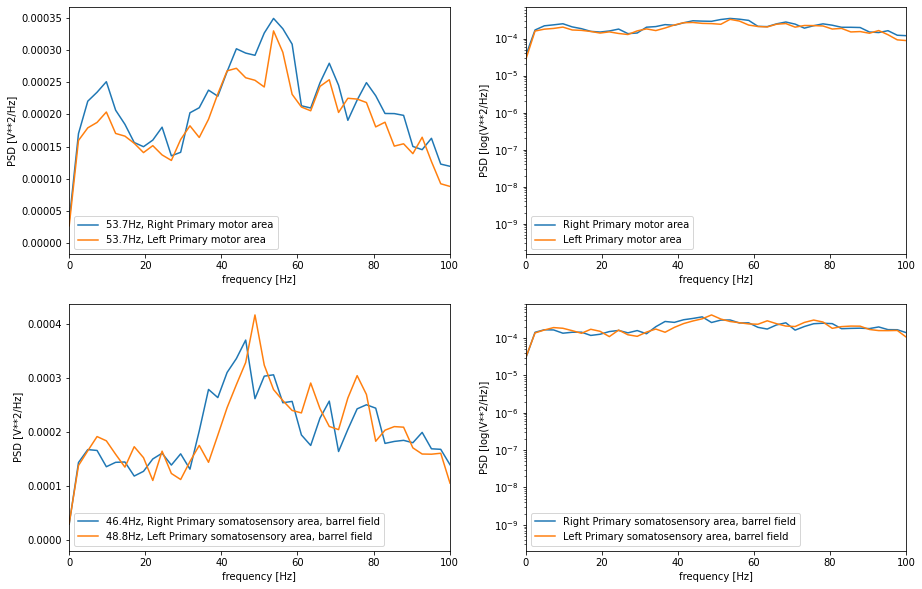

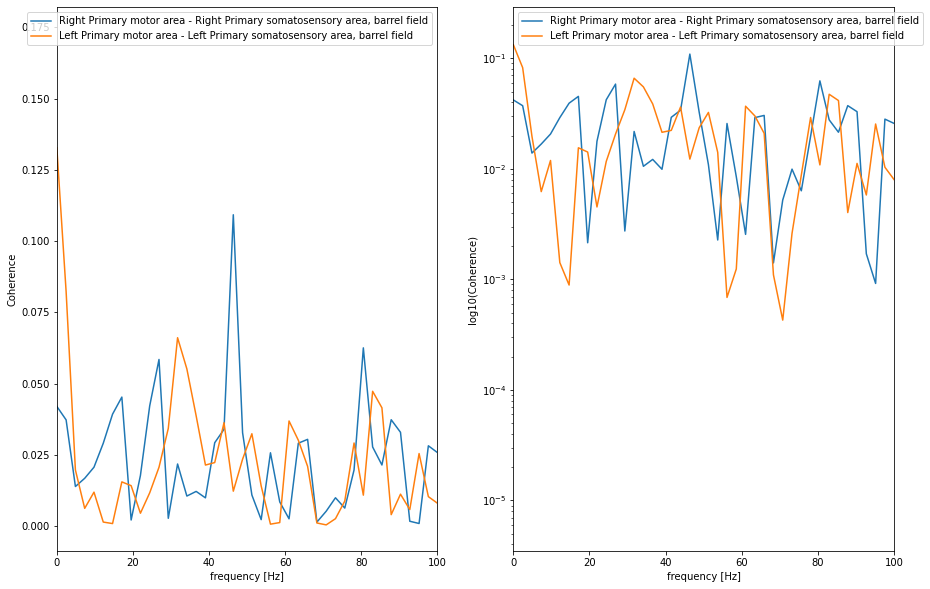

In [32]:
%matplotlib inline 

from examples.tvb_nest.notebooks.cerebellum.utils import  compute_plot_selected_spectra_coherence, compute_plot_ica

NPERSEG = np.array([256, 512, 1024, 2048, 4096])
NPERSEG = NPERSEG[np.argmin(np.abs(NPERSEG - (source_ts.shape[0]-transient/dt)))]

# Power Spectra and Coherence for M1 - S1 barrel field
compute_plot_selected_spectra_coherence(source_ts, inds["m1s1brl"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

2022-05-19 08:56:16,727 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


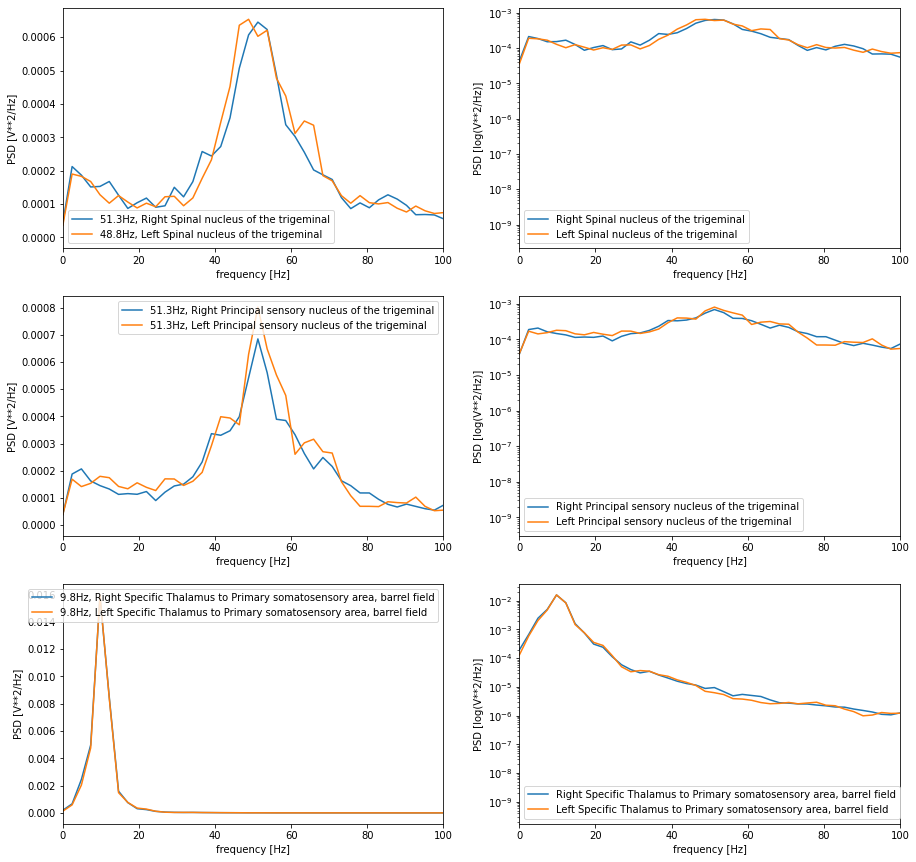

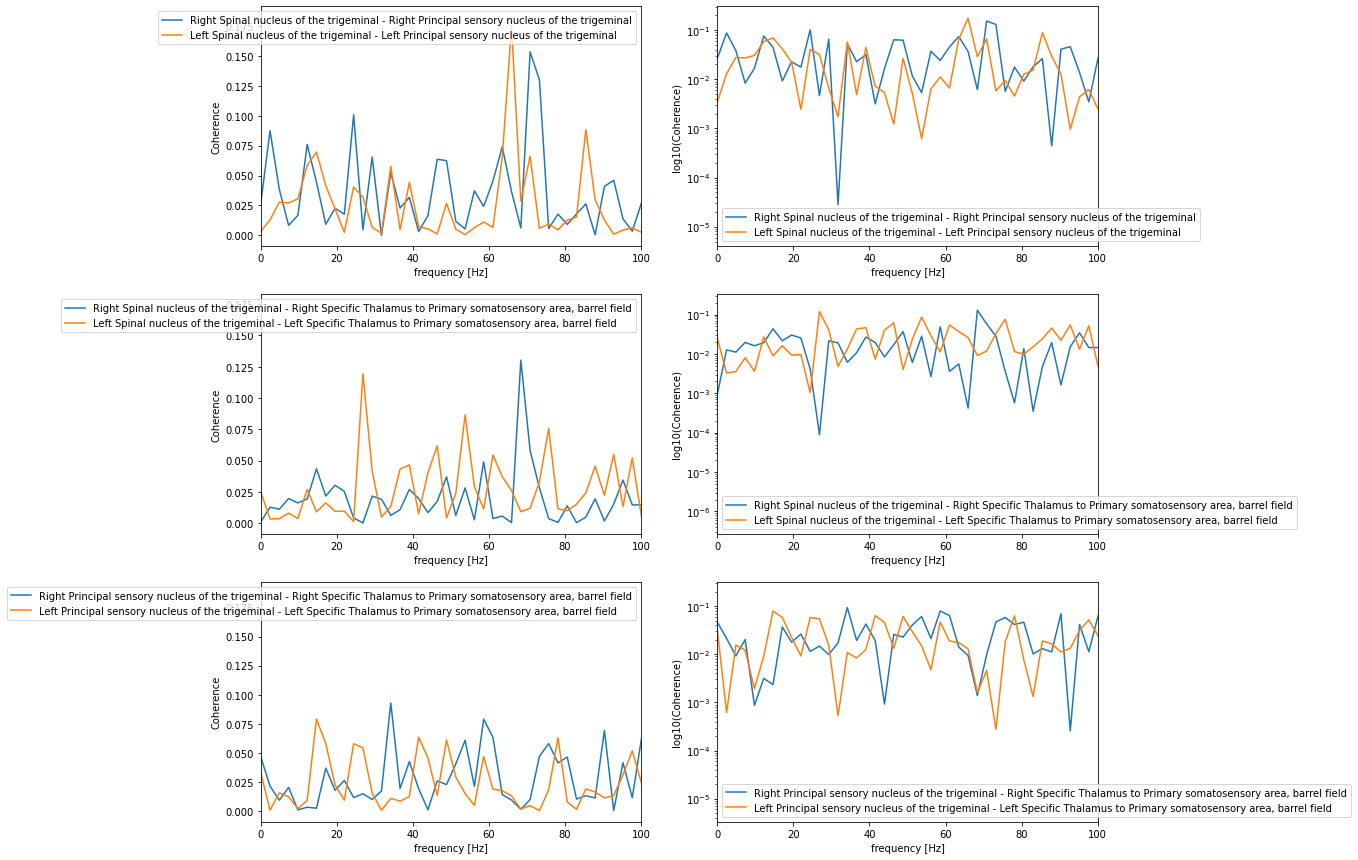

In [33]:
# Power Spectra and Coherence along the sensory pathway:
# for Medulla SPV, Sensory PONS
compute_plot_selected_spectra_coherence(source_ts, inds["sens"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

/home/docker/env/neurosci/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/home/docker/env/neurosci/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


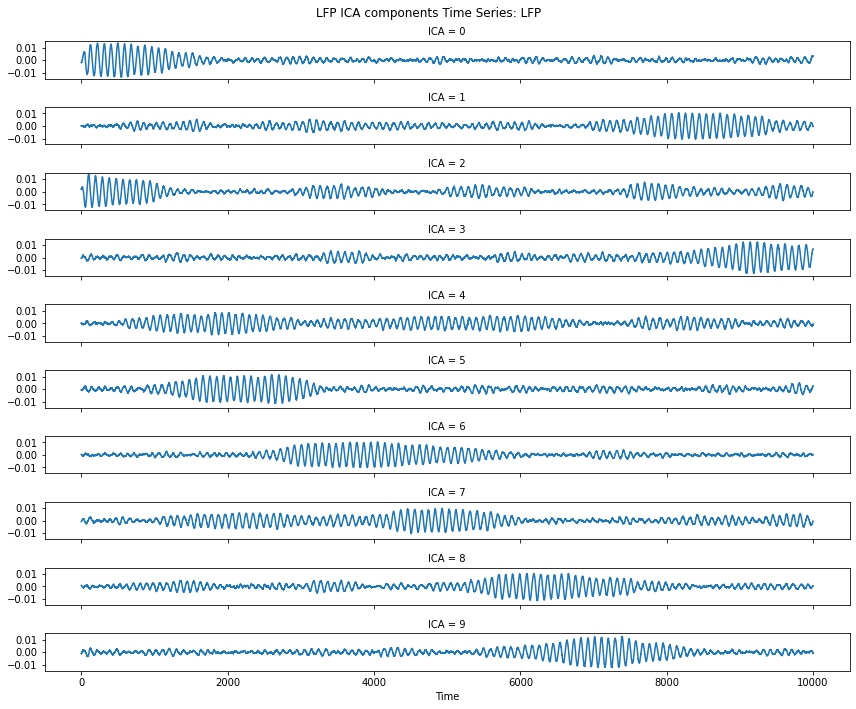

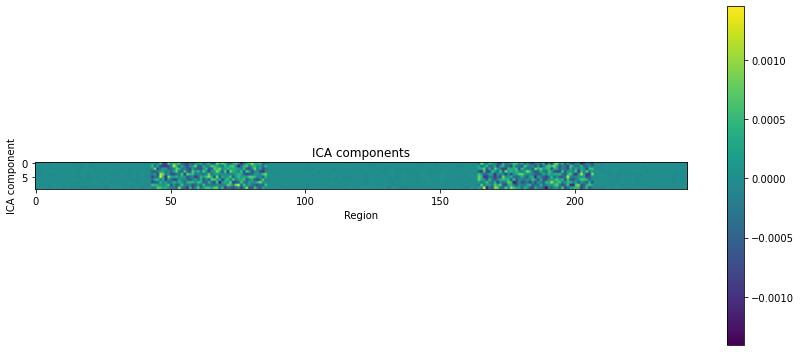

In [34]:
plotter.config.DEFAULT_SIZE = (12, 10)  # FIGSIZE
if source_ts is not None:
    # LFP (E) ICA:
    lfp_ica_comps, lfp_ics_ts, lfp_ica = compute_plot_ica(source_ts[transient:].data[:, 0, :, 0].squeeze(), 
                                                          source_ts[transient:].time,
                                                          variable="LFP", n_components=10, plotter=plotter)
    

/home/docker/env/neurosci/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/home/docker/env/neurosci/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:544: UserWarning: n_components is too large: it will be set to 9
  warnings.warn(


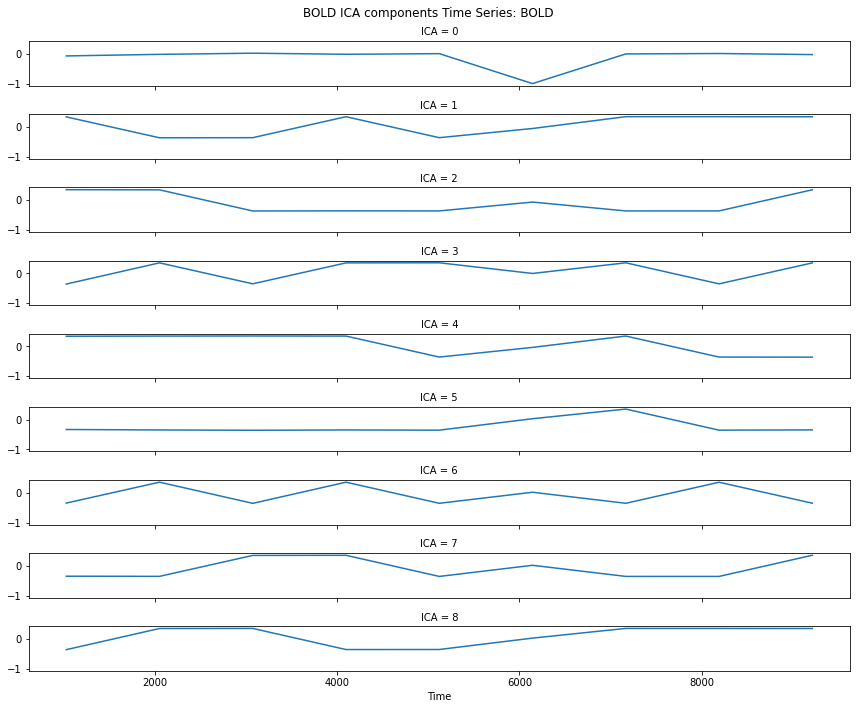

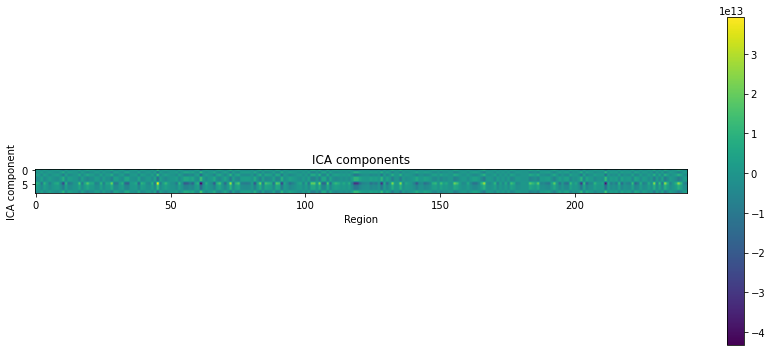

In [35]:
if bold_ts is not None:    
    # BOLD ICA:
    bold_ica_comps, bold_ics_ts, bold_ica = compute_plot_ica(bold_ts.data[:, 0, :, 0].squeeze(), bold_ts.time,
                                                             variable="BOLD", n_components=10, plotter=plotter)
    

In [36]:
if TEST:
    import matplotlib.pyplot as plt 

    # Neuronal response function
    def f(u,gain=20.0,threshold=0.0):
        output= 1./(1.+np.exp(-gain*(u-threshold))); 
        return output 
    
    # Checking that internal time delays work as expected:
    SC_dels = np.concatenate(simulator.model._SC_dels, -1).T
    ET_dels = np.concatenate(simulator.model._ET_dels, -1).T
    ET = np.array(simulator.model._cET).squeeze()
    SC = np.array(simulator.model._cSC).squeeze()
    print(SC_dels.shape)
    if THAL_CRTX_FIX:
        w_sc = 1.0
        w_et = 1.0
        d = 20
        idel = 200
    else:
        w_sc = simulator.connectivity.weights[inds['crtx'][1], inds['thalspec'][1]]
        w_et = simulator.connectivity.weights[inds['thalspec'][1], inds['crtx'][1]]
        d = simulator.connectivity.delays[inds['crtx'][1], inds['thalspec'][1]]
        idel = int(np.round(d/simulator.integrator.dt))
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    axes[0].plot(SC_dels[idel+1:, 1], 'r*', alpha=0.1, 
                 label='expected S[t-%g] -> E[t]' % d)
    axes[0].plot(source_ts.data[:, 0, inds['thalspec'][1], 0], 'b',
                 label='empirical S[t]')
    axes[0].plot(w_sc * f(SC_dels[idel+1:, 1]), 'g-*', alpha=0.1, 
                 label='expected w*sigm(S[t-%g]) -> E[t]' % d)
    axes[0].plot(SC[idel+1:, 1], 'ro', alpha=0.1, 
                 label='effective w*sigm(S[t-%g]) -> E[t]' % d)
    axes[0].plot(w_sc * f(source_ts.data[:, 0, inds['thalspec'][1], 0]), 'g', 
                 label='empirical w*sigm(S[t]) -> E[t]')
    axes[0].legend()
    
    axes[1].plot(ET_dels[idel+1:, 1], 'r*', alpha=0.1, 
                 label='expected E[t-%g] -> S[t]' % d)
    axes[1].plot(source_ts.data[:, 0, inds['crtx'][1], 0], 'b', 
                 label='empirical E[t]')
    axes[1].plot(w_et * f(ET_dels[idel+1:, 1]), 'g-*', alpha=0.1, 
                 label='expected w*sigm(E[t-%g]) -> S[t]' % d)
    axes[1].plot(ET[idel:, 1], 'ro', alpha=0.1, 
                 label='effective w*sigm(E[t-%g]) -> S[t]' % d)
    axes[1].plot(w_et * f(source_ts.data[:, 0, inds['crtx'][1], 0]), 'g', 
                 label='empirical w*sigm(E[t]) -> S[t]')
    axes[1].legend()



In [37]:
if TEST:

    # Checking that internal time delays work as expected:
    RS_dels = np.concatenate(simulator.model._RS_dels, -1).T
    SR_dels = np.concatenate(simulator.model._SR_dels, -1).T
    print(RS_dels.shape)
    plt.figure(figsize=(15, 5))
    plt.plot(RS_dels[51:, 1], 'r-*', label='expected R[t-5] -> S[t]', alpha=.1)
    plt.plot(source_ts.data[:, 1, inds["thalspec"][1], 0], 'k', label='empirical R[t-5]')
    plt.plot(SR_dels[51:, 1], 'r-o', label='expected S[t-5] -> R[t]', alpha=.1)
    plt.plot(source_ts.data[:, 0, inds["thalspec"][1], 0], 'b', label='empirical S[t-5]')
    plt.legend()

In [38]:
%matplotlib notebook

def test(source_ts, inds, cth=None, Io=0.0, transient=10000, ET=[], SC=[],
         wee=1.4 if DEMO else 0.5, 
         wei = 1.4 if DEMO else 1.0, 
         wie = -3. if DEMO else -2.0, 
         wii = -0.5, # wie = -2.,wii = -0.5,
         wertn = 0.6,
         weth =  0.6,
         wthe = 1.65, # 1.65,
         wthi = 0.2,
         wrtnth = -2.,
         wthrtn = 2.,
         # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2:
         a_e = 0.9 if DEMO else 0.3,  
         a_i = 0.9 if DEMO else 0.5, 
         a_th=0.25 if DEMO else 0.2, 
         a_rtn=0.25 if DEMO else 0.2, 
         i_e = -0.35,
         i_i = -0.3,
         i_th = 0.5,
         i_rtn = -0.8
        ):
    
    mind = inds["m1s1brl"][0]
    thind = inds["motor"][0]
    e = source_ts[-transient:-transient+2000, [0], mind].data.squeeze()
    i = source_ts[-transient:-transient+2000, [1], mind].data.squeeze()
    fe2 = source_ts[-transient:-transient+2000, [2], mind].data.squeeze()
    s = source_ts[-transient:-transient+2000, [0], thind].data.squeeze()
    r = source_ts[-transient:-transient+2000, [1], thind].data.squeeze()
    fs2 = source_ts[-transient:-transient+2000, [2], thind].data.squeeze()
    t = source_ts[-transient:-transient+2000, [0], mind].time
    e_sigm = f(e)
    i_sigm = f(i)
    # Delayed s by tau_ct = 20
    sd_ct = source_ts[-transient-200:-transient+2000-200, [0], thind].data.squeeze()
    sd_ct_sigm = f(sd_ct)
        
    # Delayed e by tau_ct = 20
    ed = source_ts[-transient-200:-transient+2000-200, [0], mind].data.squeeze()
    ed_sigm = f(ed)
    # Delayed s by tau_tt = 5
    sd_tt = source_ts[-transient-50:-transient+2000-50, [0], thind].data.squeeze()
    sd_tt_sigm = f(sd_tt)
    # Delayed r by tau_tt = 5
    rd_tt = source_ts[-transient-50:-transient+2000-50, [1], thind].data.squeeze()
    rd_tt_sigm = f(rd_tt)
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    alpha = 0.5
    lw = 2.0
    
    # dedt:
    ee = wee*e_sigm # 1.4
    ie = wie*i_sigm # -3.0
    se = wthe*sd_ct_sigm  # 1.65
    fe = ee + ie + se + i_e
    dedt = a_e*(-e + fe) 
    dedt2 = np.diff(e) / 0.1 / 0.1 
    axes[0, 0].plot(t, e, "b", label="E", alpha=alpha)
    axes[0, 0].plot(t, ee, "b--", label="wee*sigm(E)", alpha=alpha)
    axes[0, 0].plot(t, ie, "g--", label="wie*sigm(I)", alpha=alpha)
    if len(SC):
        se2 = wthe*SC[-transient:-transient+2000, 1]
        axes[0, 0].plot(t, se2, "k", label="wse*sigm(S[t-20])_emp", alpha=alpha)
    axes[0, 0].plot(t, se, "m--", label="wse*sigm(S[t-20])_exp", alpha=alpha)
    axes[0, 0].plot(t, fe, "c", label="f_e_exp")  # , alpha=alpha
    axes[0, 0].plot(t, fe2, "k--", label="f_e_emp", alpha=alpha) # 
    axes[0, 0].plot(t, dedt, "k", label="dEdt_exp", linewidth=lw)
    axes[0, 0].plot(t[:-1], dedt2, 'r--', label="dEdt_emp", linewidth=lw)
    axes[0, 0].legend()
    axes[0, 0].set_title("E")
    
    # didt:
    ie = wei*e_sigm # 1.4
    ii = wii*i_sigm # -0.5
    si = wthi * sd_ct_sigm  # 0.2
    fi = ie + ii + si + i_i
    didt = a_i*(-i + fi) 
    didt2 = np.diff(i) / 0.1 / 0.1 
    axes[0, 1].plot(t, i, "b", label="I", alpha=alpha)
    axes[0, 1].plot(t, ii, "b--", label="wii*sigm(I)", alpha=alpha)
    axes[0, 1].plot(t, ie, "g--", label="wei*sigm(E)", alpha=alpha)
    axes[0, 1].plot(t, si, "m--", label="wsi*sigm(S[t-20])", alpha=alpha)
    axes[0, 1].plot(t, fi, "c", label="f_i", alpha=alpha)
    axes[0, 1].plot(t, didt, "k", label="dIdt_exp", linewidth=lw)
    axes[0, 1].plot(t[:-1], didt2, 'r--', label="dIdt_emp", linewidth=lw)
    axes[0, 1].legend()
    axes[0, 1].set_title("I")
    
    # dsdt:
    es = weth * ed_sigm
    rs = wrtnth * rd_tt_sigm
    fs = es + rs + i_th + Io
    dsdt = a_th*(-s + fs)
    dsdt2 = np.diff(s) / 0.1 / 0.1
    axes[1, 0].plot(t, s, "b", label="S", alpha=alpha)
    if len(ET):
        es2 = weth*ET[-transient:-transient+2000, 1].squeeze()
    axes[1, 0].plot(t, es2, "y", label="wes*sigm(E[t-20])_emp")
    axes[1, 0].plot(t, es, "g--", label="wes*sigm(E[t-20])", alpha=alpha)
    axes[1, 0].plot(t, rs, "m--", label="wsr*sigm(R[t-5])", alpha=alpha)
    axes[1, 0].plot(t, fs, "c", label="f_s_exp")  # , alpha=alpha
    axes[1, 0].plot(t, fs2, "k--", label="f_s_emp", alpha=alpha)  # 
    axes[1, 0].plot(t, dsdt, "k", label="dSdt_exp", linewidth=lw)
    axes[1, 0].plot(t[:-1], dsdt2, 'r--', label="dSdt_emp", linewidth=lw)
    axes[1, 0].legend()
    axes[1, 0].set_title("S")
    
    # drdt:
    er = wertn * ed_sigm
    sr = wthrtn * sd_tt_sigm
    fr = er + sr + i_rtn
    drdt = a_rtn*(-r + fr) 
    drdt2 = np.diff(r) / 0.1 / 0.1 
    axes[1, 1].plot(t, r, "b", label="R", alpha=alpha)
    if len(ET):
        er2 = wertn*ET[-transient:-transient+2000, 1].squeeze()
    axes[1, 1].plot(t, er2, "y", label="wer*sigm(E[t-20])_emp")
    axes[1, 1].plot(t, er, "g--", label="wer*sigm(E[t-20])", alpha=alpha)
    axes[1, 1].plot(t, sr, "m--", label="wsr*sigm(S[t-5])", alpha=alpha)
    axes[1, 1].plot(t, fr, "c", label="f_r", alpha=alpha)
    axes[1, 1].plot(t, drdt, "k", label="dRdt_exp", linewidth=lw)
    axes[1, 1].plot(t[:-1], drdt2, 'r--', label="dRdt_emp", linewidth=lw)
    axes[1, 1].legend()
    axes[1, 1].set_title("R")
    
    fig.tight_layout()

if TEST:    
    test(source_ts, inds, Io=I_o,
         ET=np.array(simulator.model._cET).squeeze(),
         SC=np.array(simulator.model._cSC).squeeze()
        )


# References

1 Sanz Leon P, Knock SA , Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK. 2013. <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling and multimodal neuroimaging. <br>
  Brain Connectivity 3:121–145. <br>

3 Griffiths JD, McIntosh AR, Lefebvre J. 2020.   <br>
  A Connectome-Based, Corticothalamic Model of State- <br>
  and Stimulation-Dependent Modulation of Rhythmic Neural Activity and Connectivity <br>
  Frontiers in Computational Neuroscience (vol. 14. doi: 10.3389/fncom.2020.575143) <br>
  https://www.frontiersin.org/articles/10.3389/fncom.2020.575143/full#h12
  
4 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

(90000, 86)
(90000, 70)
(90000, 86)


/tmp/ipykernel_171/3322322905.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/docker/env/neurosci/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/docker/env/neurosci/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


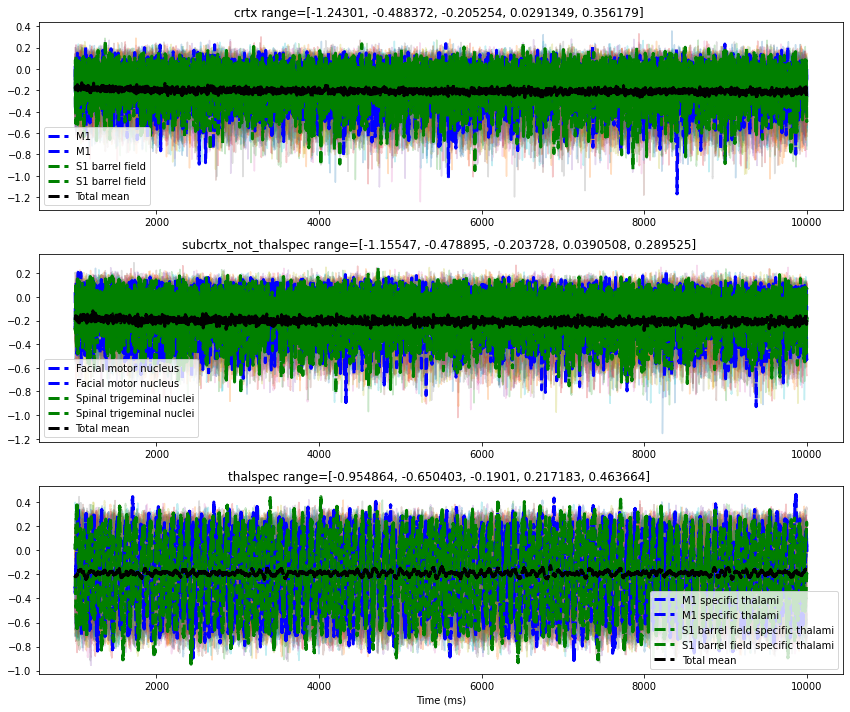

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

data = source_ts.data
time = source_ts.time

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for iT, regs in enumerate(["crtx", "subcrtx_not_thalspec", "thalspec"]):
    transient = 10000
    dat = data[transient:, 0, inds[regs]].squeeze()
    print(dat.shape)
    axes[iT].plot(time[transient:], dat, alpha=0.25)
    if iT == 0:
        axes[iT].plot(time[transient:], data[transient:, 0, inds["m1"]].squeeze(), 
                      'b--', linewidth=3, label='M1')
        axes[iT].plot(time[transient:], data[transient:, 0, inds["s1brl"]].squeeze(), 
                      'g--', linewidth=3, label='S1 barrel field')
    elif iT == 1:
        axes[iT].plot(time[transient:], data[transient:, 0, inds["facial"]].squeeze(), 
                      'b--', linewidth=3, label='Facial motor nucleus')
        axes[iT].plot(time[transient:], data[transient:, 0, inds["trigeminal"]].squeeze(), 
                      'g--', linewidth=3, label='Spinal trigeminal nuclei')
    else:
        axes[iT].plot(time[transient:], data[transient:, 0, [44, 166]].squeeze(), 
                      'b--', linewidth=3, label='M1 specific thalami')
        axes[iT].plot(time[transient:], data[transient:, 0, [47, 169]].squeeze(), 
                      'g--', linewidth=3, label='S1 barrel field specific thalami')
        axes[iT].set_xlabel('Time (ms)')
    axes[iT].plot(time[transient:], dat.mean(axis=1), 'k--', linewidth=3, label='Total mean')
    axes[iT].legend()
    axes[iT].set_title("%s range=[%g, %g, %g, %g, %g] " % 
                       (regs, dat.min(), np.percentile(dat, 5), dat.mean(), np.percentile(dat, 95), dat.max()))
fig.tight_layout()

2022-05-19 08:58:22,638 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,643 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,649 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,655 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,662 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,673 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-19 08:58:22,681 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

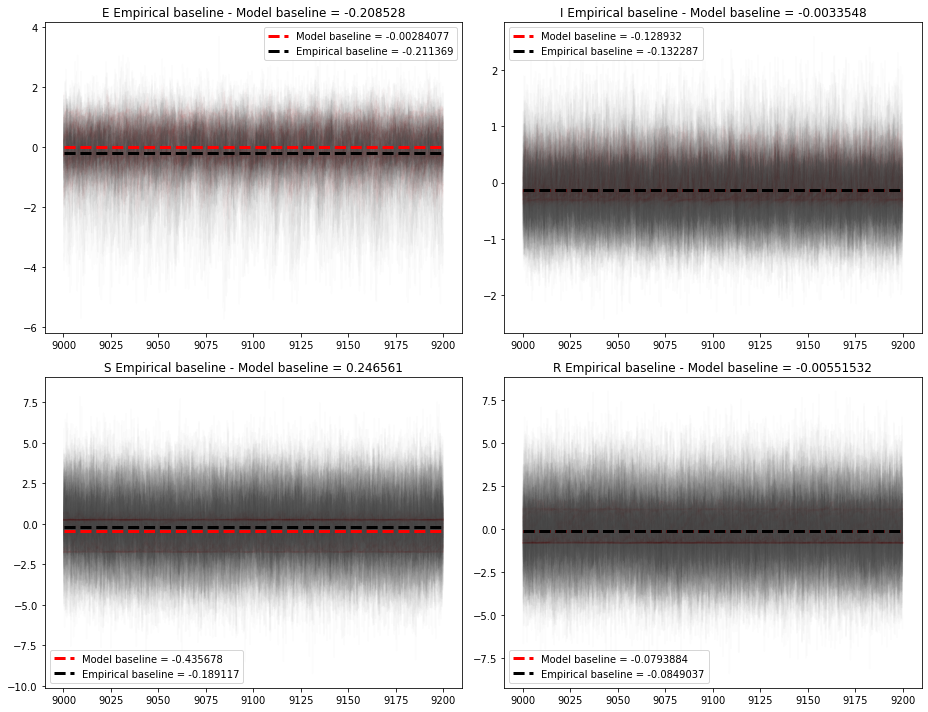

In [40]:
def test(source_ts, inds, cth=None, Io=0.0, transient=10000, ET=[], SC=[],
         wee=1.4 if DEMO else 0.5, 
         wei = 1.4 if DEMO else 1.0, 
         wie = -3. if DEMO else -2.0, 
         wii = -0.5, # wie = -2.,wii = -0.5,
         wertn = 0.6,
         weth =  0.6,
         wthe = 1.65, # 1.65,
         wthi = 0.2,
         wrtnth = -2.,
         wthrtn = 2.,
         # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2:
         a_e = 0.9 if DEMO else 0.3,  
         a_i = 0.9 if DEMO else 0.5, 
         a_th=0.25 if DEMO else 0.2, 
         a_rtn=0.25 if DEMO else 0.2, 
         i_e = -0.35,
         i_i = -0.3,
         i_th = 0.5,
         i_rtn = -0.8
        ):
    
    # Neuronal response function
    def f(u,gain=20.0,threshold=0.0):
        output= 1./(1.+np.exp(-gain*(u-threshold))); 
        return output 
    
    mind = inds['crtx']      # inds["m1s1brl"][0]
    thind = inds['thalspec'] # inds["motor"][0]
    e = source_ts[-transient:-transient+2000, [0], mind].data.squeeze()
    i = source_ts[-transient:-transient+2000, [1], mind].data.squeeze()
    s = source_ts[-transient:-transient+2000, [0], thind].data.squeeze()
    r = source_ts[-transient:-transient+2000, [1], thind].data.squeeze()
    t = source_ts[-transient:-transient+2000, [0], mind].time
    e_sigm = f(e)
    i_sigm = f(i)
    # Delayed s by tau_ct = 20
    sd_ct = source_ts[-transient-200:-transient+2000-200, [0], thind].data.squeeze()
    sd_ct_sigm = f(sd_ct)
        
    # Delayed e by tau_ct = 20
    ed = source_ts[-transient-200:-transient+2000-200, [0], mind].data.squeeze()
    ed_sigm = f(ed)
    # Delayed s by tau_tt = 5
    sd_tt = source_ts[-transient-50:-transient+2000-50, [0], thind].data.squeeze()
    sd_tt_sigm = f(sd_tt)
    # Delayed r by tau_tt = 5
    rd_tt = source_ts[-transient-50:-transient+2000-50, [1], thind].data.squeeze()
    rd_tt_sigm = f(rd_tt)
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    alpha = 0.01
    lw = 3
    nt = e.shape[0]
    
    # dedt:
    ee = wee*e_sigm # 1.4
    ie = wie*i_sigm # -3.0
    se = wthe*sd_ct_sigm  # 1.65
    fe = ee + ie + se + i_e
    # dedt = a_e*(-e + fe) 
    dedt2 = np.diff(e, axis=0) / 0.1 / 0.1 
    fe2 = dedt2 / a_e + e[:-1]
    fe_m = fe.mean()
    fe2_m = fe2.mean()
    axes[0, 0].plot(t, fe, "r", alpha=alpha)  # 
    axes[0, 0].plot(t[:-1], fe2, "k", alpha=alpha) # 
    axes[0, 0].plot([t[0], t[-1]], [fe_m, fe_m], 'r--', linewidth=lw, label="Model baseline = %g" % fe_m)
    axes[0, 0].plot([t[0], t[-1]], [fe2_m, fe2_m], 'k--', linewidth=lw, label="Empirical baseline = %g" % fe2_m)
    axes[0, 0].legend()
    axes[0, 0].set_title("E Empirical baseline - Model baseline = %g" % (fe2_m - fe_m))
    
    # didt:
    ie = wei*e_sigm # 1.4
    ii = wii*i_sigm # -0.5
    si = wthi * sd_ct_sigm  # 0.2
    fi = ie + ii + si + i_i
    # didt = a_i*(-i + fi) 
    didt2 = np.diff(i, axis=0) / 0.1 / 0.1 
    fi2 = didt2 / a_i + i[:-1]
    fi_m = fi.mean()
    fi2_m = fi2.mean()
    axes[0, 1].plot(t, fi, "r", alpha=alpha)
    axes[0, 1].plot(t[:-1], fi2, 'k', alpha=alpha)
    axes[0, 1].plot([t[0], t[-1]], [fi_m, fi_m], 'r--', linewidth=lw, label="Model baseline = %g" % fi_m)
    axes[0, 1].plot([t[0], t[-1]], [fi2_m, fi2_m], 'k--', linewidth=lw, label="Empirical baseline = %g" % fi2_m)
    axes[0, 1].legend()
    axes[0, 1].set_title("I Empirical baseline - Model baseline = %g" % (fi2_m - fi_m))
    
    # dsdt:
    es = weth * ed_sigm
    rs = wrtnth * rd_tt_sigm
    fs = es + rs + i_th + Io
    # dsdt = a_th*(-s + fs)
    dsdt2 = np.diff(s, axis=0) / 0.1 / 0.1
    fs2 = dsdt2 / a_th + s[:-1]
    fs_m = fs.mean()
    fs2_m = fs2.mean()
    axes[1, 0].plot(t, fs, "r", alpha=alpha)  #
    axes[1, 0].plot(t[:-1], fs2, "k", alpha=alpha)  # 
    axes[1, 0].plot([t[0], t[-1]], [fs_m, fs_m], 'r--', linewidth=lw, label="Model baseline = %g" % fs_m)
    axes[1, 0].plot([t[0], t[-1]], [fs2_m, fs2_m], 'k--', linewidth=lw, label="Empirical baseline = %g" % fs2_m)
    axes[1, 0].legend()
    axes[1, 0].set_title("S Empirical baseline - Model baseline = %g" % (fs2_m - fs_m))
    
    # drdt:
    er = wertn * ed_sigm
    sr = wthrtn * sd_tt_sigm
    fr = er + sr + i_rtn
    # drdt = a_rtn*(-r + fr) 
    drdt2 = np.diff(r, axis=0) / 0.1 / 0.1 
    fr2 = drdt2 / a_rtn + r[:-1]
    fr_m = fr.mean()
    fr2_m = fr2.mean()
    axes[1, 1].plot(t, fr, "r", alpha=alpha)
    axes[1, 1].plot(t[:-1], fr2, 'k', alpha=alpha)
    axes[1, 1].plot([t[0], t[-1]], [fr_m, fr_m], 'r--', linewidth=lw, label="Model baseline = %g" % fr_m)
    axes[1, 1].plot([t[0], t[-1]], [fr2_m, fr2_m], 'k--', linewidth=lw, label="Empirical baseline = %g" % fr2_m)
    axes[1, 1].legend()
    axes[1, 1].set_title("R Empirical baseline - Model baseline = %g" % (fr2_m - fr_m))
    
    fig.tight_layout()
    
test(source_ts, inds, 
     Io=simulator.model.I_o[0].item(), 
     i_e=simulator.model.I_e[0].item(), 
     i_th=simulator.model.I_s[0].item(), 
     wie=simulator.model.w_ie[0].item(), 
     wrtnth=simulator.model.w_rs[0].item())

In [41]:
source_ts

In [42]:
source_ts.data[:-10000, 0, inds['thalspec'], 0].mean()

-0.19186884976059024

In [43]:
inds["facial"]

array([101, 222])